In [1]:
import math
import os
import sys
from enum import IntEnum

import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.relpath("../../Mapping/grid_map_lib/"))
try:
    from grid_map_lib import GridMap
except ImportError:
    raise

do_animation = True

In [2]:
class SweepSearcher:
    class SweepDirection(IntEnum):
        UP = 1
        DOWN = -1

    class MovingDirection(IntEnum):
        RIGHT = 1
        LEFT = -1

    def __init__(self, mdirection, sdirection, xinds_goaly, goaly):
        self.moving_direction = mdirection
        self.sweep_direction = sdirection
        self.turing_window = []
        self.update_turning_window()
        self.xinds_goaly = xinds_goaly
        self.goaly = goaly

    def move_target_grid(self, cxind, cyind, gmap):
        nxind = self.moving_direction + cxind
        nyind = cyind

        # found safe grid
        if not gmap.check_occupied_from_xy_index(nxind, nyind, occupied_val=0.5):
            return nxind, nyind
        else:  # occupided
            ncxind, ncyind = self.find_safe_turning_grid(cxind, cyind, gmap)
            if (ncxind is None) and (ncyind is None):
                # moving backward
                ncxind = -self.moving_direction + cxind
                ncyind = cyind
                if gmap.check_occupied_from_xy_index(ncxind, ncyind):
                    # moved backward, but the grid is occupied by obstacle
                    return None, None
            else:
                # keep moving until end
                while not gmap.check_occupied_from_xy_index(ncxind + self.moving_direction, ncyind, occupied_val=0.5):
                    ncxind += self.moving_direction
                self.swap_moving_direction()
            return ncxind, ncyind

    def find_safe_turning_grid(self, cxind, cyind, gmap):

        for (dxind, dyind) in self.turing_window:

            nxind = dxind + cxind
            nyind = dyind + cyind

            # found safe grid
            if not gmap.check_occupied_from_xy_index(nxind, nyind, occupied_val=0.5):
                return nxind, nyind

        return None, None

    def is_search_done(self, gmap):
        for ix in self.xinds_goaly:
            if not gmap.check_occupied_from_xy_index(ix, self.goaly, occupied_val=0.5):
                return False

        # all lower grid is occupied
        return True

    def update_turning_window(self):
        self.turing_window = [
            (self.moving_direction, 0.0),
            (self.moving_direction, self.sweep_direction),
            (0, self.sweep_direction),
            (-self.moving_direction, self.sweep_direction),
        ]

    def swap_moving_direction(self):
        self.moving_direction *= -1
        self.update_turning_window()

    def search_start_grid(self, grid_map):
        xinds = []
        y_ind = 0
        if self.sweep_direction == self.SweepDirection.DOWN:
            xinds, y_ind = search_free_grid_index_at_edge_y(grid_map, from_upper=True)
        elif self.sweep_direction == self.SweepDirection.UP:
            xinds, y_ind = search_free_grid_index_at_edge_y(grid_map, from_upper=False)

        if self.moving_direction == self.MovingDirection.RIGHT:
            return min(xinds), y_ind
        elif self.moving_direction == self.MovingDirection.LEFT:
            return max(xinds), y_ind

        raise ValueError("self.moving direction is invalid ")

In [3]:
def find_sweep_direction_and_start_posi(ox, oy):
    # find sweep_direction
    max_dist = 0.0
    vec = [0.0, 0.0]
    sweep_start_pos = [0.0, 0.0]
    for i in range(len(ox) - 1):
        dx = ox[i + 1] - ox[i]
        dy = oy[i + 1] - oy[i]
        d = np.sqrt(dx ** 2 + dy ** 2)

        if d > max_dist:
            max_dist = d
            vec = [dx, dy]
            sweep_start_pos = [ox[i], oy[i]]

    return vec, sweep_start_pos


def convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_posi):
    tx = [ix - sweep_start_posi[0] for ix in ox]
    ty = [iy - sweep_start_posi[1] for iy in oy]

    th = math.atan2(sweep_vec[1], sweep_vec[0])

    c = np.cos(-th)
    s = np.sin(-th)

    rx = [ix * c - iy * s for (ix, iy) in zip(tx, ty)]
    ry = [ix * s + iy * c for (ix, iy) in zip(tx, ty)]

    return rx, ry


def convert_global_coordinate(x, y, sweep_vec, sweep_start_posi):
    th = math.atan2(sweep_vec[1], sweep_vec[0])
    c = np.cos(th)
    s = np.sin(th)

    tx = [ix * c - iy * s for (ix, iy) in zip(x, y)]
    ty = [ix * s + iy * c for (ix, iy) in zip(x, y)]

    rx = [ix + sweep_start_posi[0] for ix in tx]
    ry = [iy + sweep_start_posi[1] for iy in ty]

    return rx, ry


def search_free_grid_index_at_edge_y(grid_map, from_upper=False):
    yind = None
    xinds = []

    if from_upper:
        xrange = range(grid_map.height)[::-1]
        yrange = range(grid_map.width)[::-1]
    else:
        xrange = range(grid_map.height)
        yrange = range(grid_map.width)

    for iy in xrange:
        for ix in yrange:
            if not grid_map.check_occupied_from_xy_index(ix, iy):
                yind = iy
                xinds.append(ix)
        if yind:
            break

    return xinds, yind


def setup_grid_map(ox, oy, reso, sweep_direction, offset_grid=10):
    width = math.ceil((max(ox) - min(ox)) / reso) + offset_grid
    height = math.ceil((max(oy) - min(oy)) / reso) + offset_grid
    center_x = np.mean(ox)
    center_y = np.mean(oy)

    grid_map = GridMap(width, height, reso, center_x, center_y)

    grid_map.set_value_from_polygon(ox, oy, 1.0, inside=False)

    grid_map.expand_grid()

    xinds_goaly = []
    goaly = 0
    if sweep_direction == SweepSearcher.SweepDirection.UP:
        xinds_goaly, goaly = search_free_grid_index_at_edge_y(grid_map, from_upper=True)
    elif sweep_direction == SweepSearcher.SweepDirection.DOWN:
        xinds_goaly, goaly = search_free_grid_index_at_edge_y(grid_map, from_upper=False)

    return grid_map, xinds_goaly, goaly


def sweep_path_search(sweep_searcher, gmap, grid_search_animation=False):
    # search start grid
    cxind, cyind = sweep_searcher.search_start_grid(gmap)
    if not gmap.set_value_from_xy_index(cxind, cyind, 0.5):
        print("Cannot find start grid")
        return [], []

    x, y = gmap.calc_grid_central_xy_position_from_xy_index(cxind, cyind)
    px, py = [x], [y]

    if grid_search_animation:
        fig, ax = plt.subplots()

    while True:
        cxind, cyind = sweep_searcher.move_target_grid(cxind, cyind, gmap)

        if sweep_searcher.is_search_done(gmap) or (cxind is None or cyind is None):
            print("Done")
            break

        x, y = gmap.calc_grid_central_xy_position_from_xy_index(
            cxind, cyind)

        px.append(x)
        py.append(y)

        gmap.set_value_from_xy_index(cxind, cyind, 0.5)

        if grid_search_animation:
            gmap.plot_grid_map(ax=ax)
            plt.pause(1.0)

    gmap.plot_grid_map()

    return px, py


def planning(ox, oy, reso,
             moving_direction=SweepSearcher.MovingDirection.RIGHT,
             sweeping_direction=SweepSearcher.SweepDirection.UP,
             ):
    sweep_vec, sweep_start_posi = find_sweep_direction_and_start_posi(ox, oy)

    rox, roy = convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_posi)

    gmap, xinds_goaly, goaly = setup_grid_map(rox, roy, reso, sweeping_direction)

    sweep_searcher = SweepSearcher(moving_direction, sweeping_direction, xinds_goaly, goaly)

    px, py = sweep_path_search(sweep_searcher, gmap)

    rx, ry = convert_global_coordinate(px, py, sweep_vec, sweep_start_posi)

    print("Path length:", len(rx))

    return rx, ry

In [4]:
def planning_animation(ox, oy, reso):  # pragma: no cover
    px, py = planning(ox, oy, reso)

    # animation
    if do_animation:
        for ipx, ipy in zip(px, py):
            plt.cla()
            plt.plot(ox, oy, "-xb")
            plt.plot(px, py, "-r")
            plt.plot(ipx, ipy, "or")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.1)

    plt.cla()
    plt.plot(ox, oy, "-xb")
    plt.plot(px, py, "-r")
    plt.axis("equal")
    plt.grid(True)
    plt.pause(0.1)

In [5]:
def main():  # pragma: no cover
    print("start!!")

#     ox = [0.0, 20.0, 50.0, 100.0, 130.0, 40.0, 0.0]
#     oy = [0.0, -20.0, 0.0, 30.0, 60.0, 80.0, 0.0]
#     reso = 5.0
#     planning_animation(ox, oy, reso)

#     ox = [0.0, 50.0, 50.0, 0.0, 0.0]
#     oy = [0.0, 0.0, 30.0, 30.0, 0.0]
#     reso = 1.3
#     planning_animation(ox, oy, reso)

    ox = [0.0, 20.0, 50.0, 200.0, 130.0, 40.0, 0.0]
    oy = [0.0, -80.0, 0.0, 30.0, 60.0, 80.0, 0.0]
    reso = 5.0
    planning_animation(ox, oy, reso)

    plt.show()

    print("done!!")

start!!
Done
Path length: 337


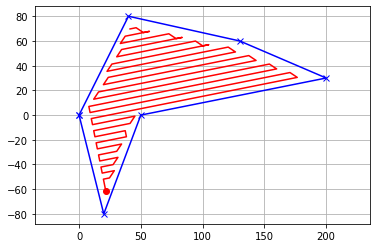

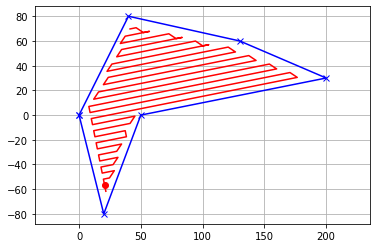

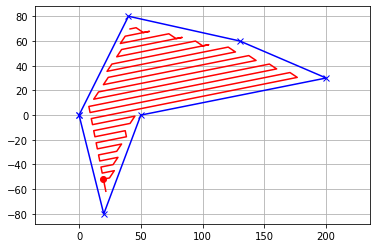

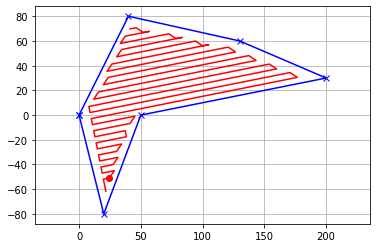

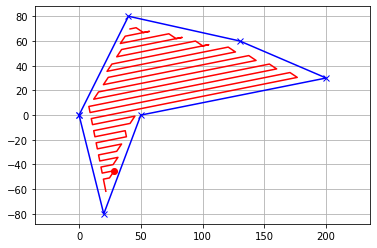

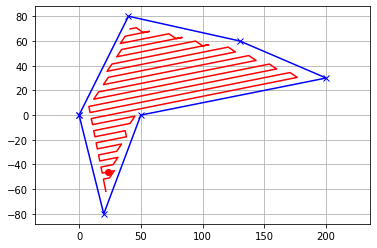

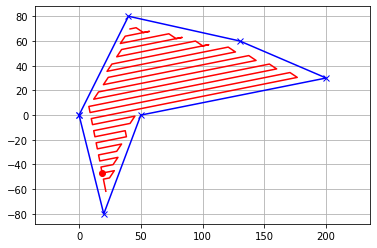

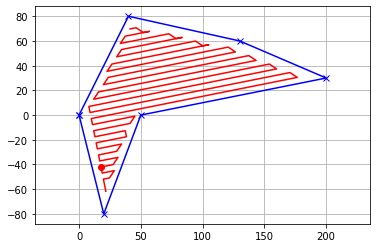

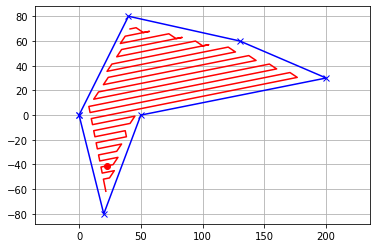

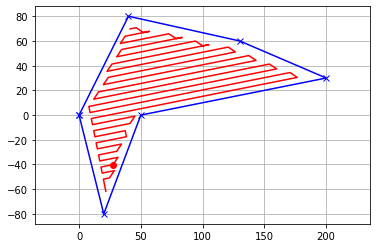

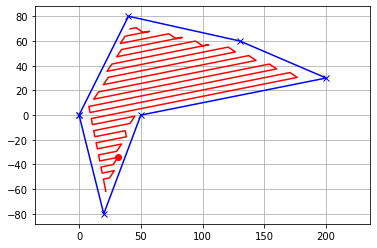

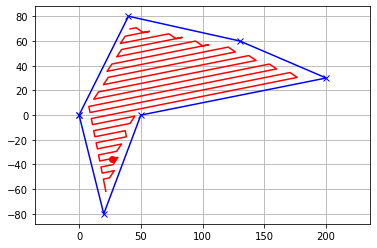

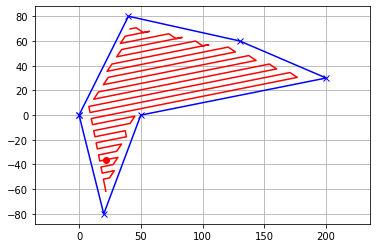

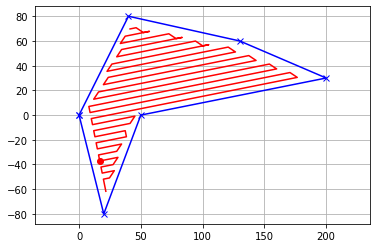

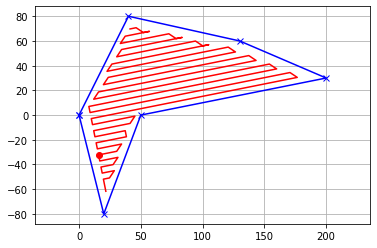

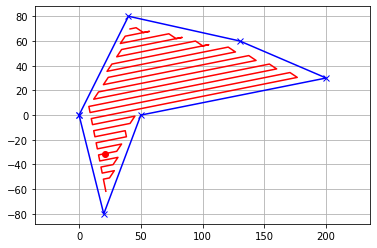

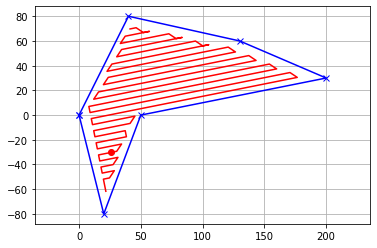

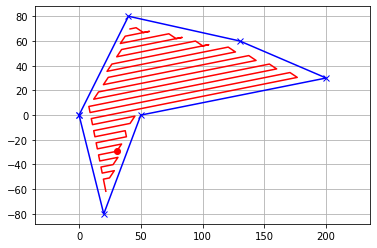

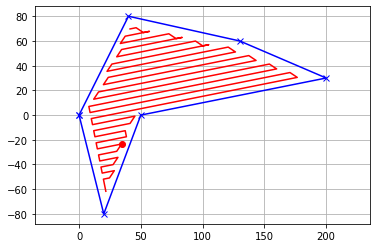

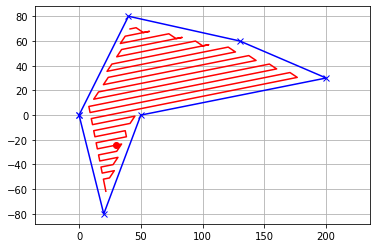

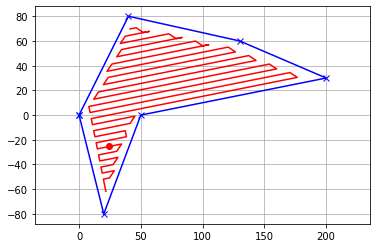

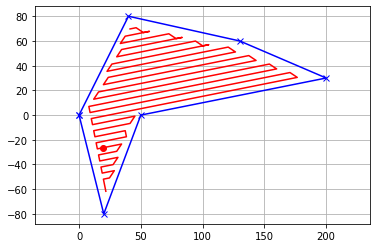

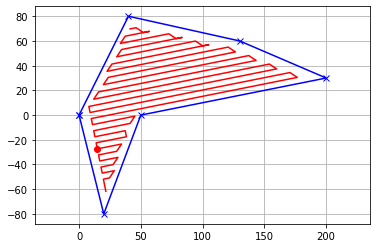

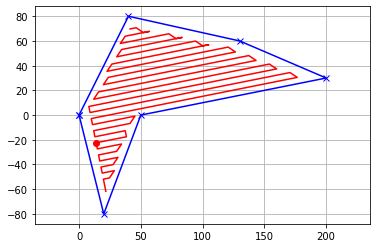

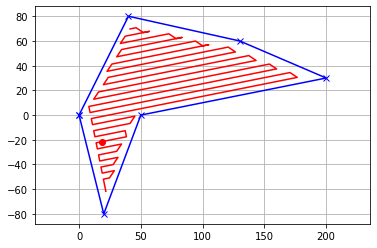

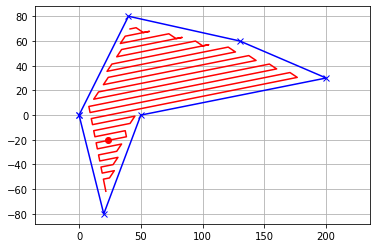

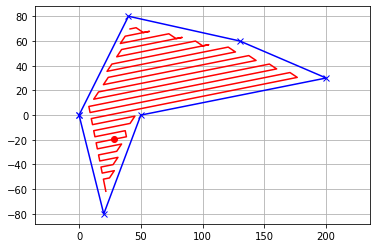

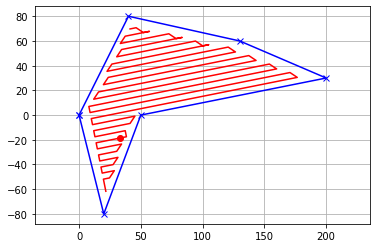

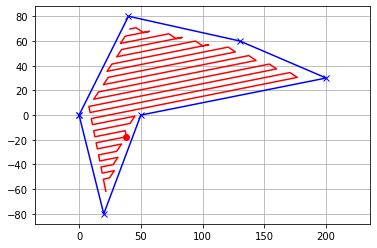

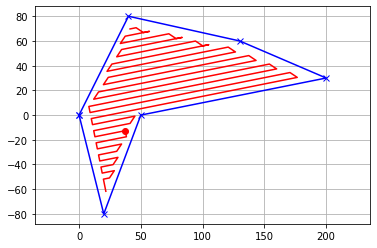

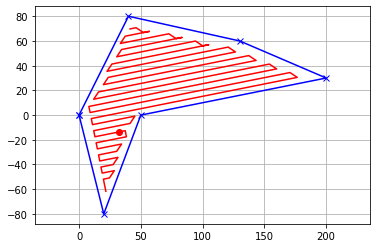

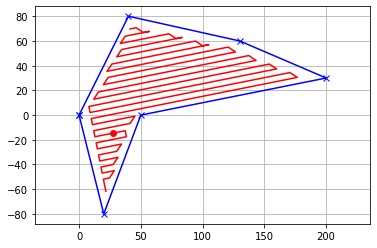

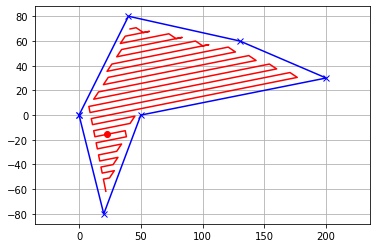

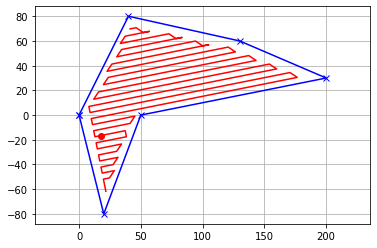

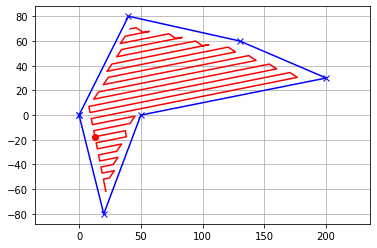

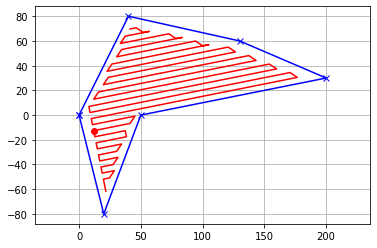

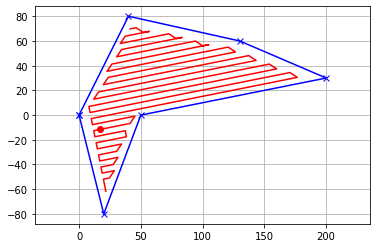

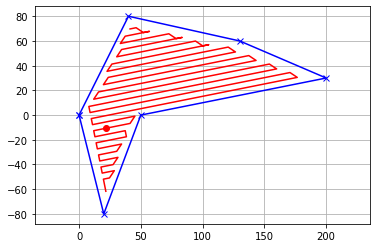

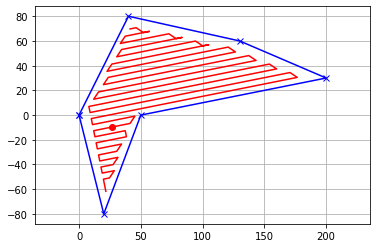

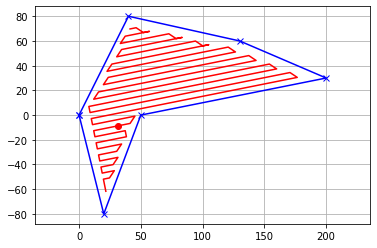

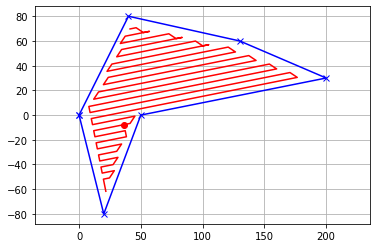

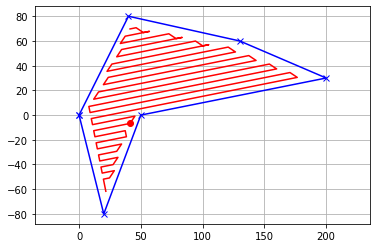

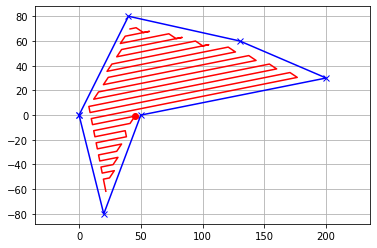

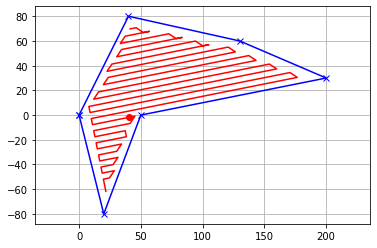

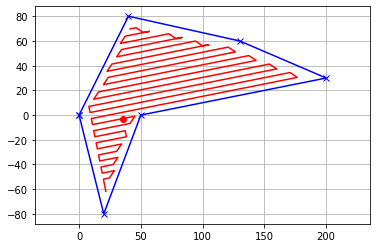

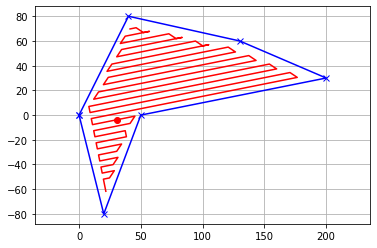

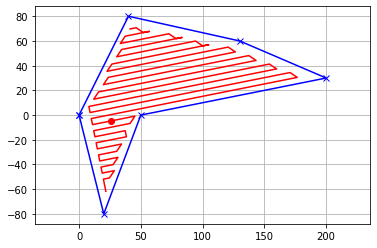

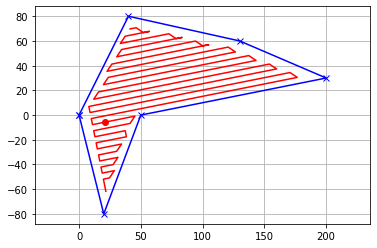

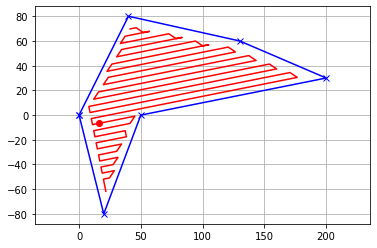

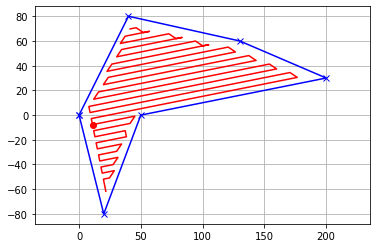

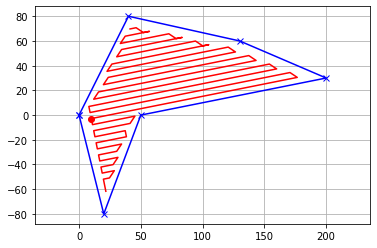

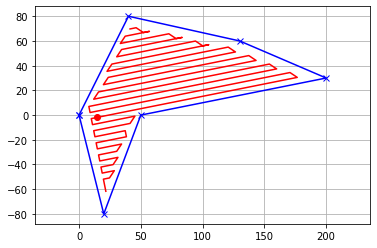

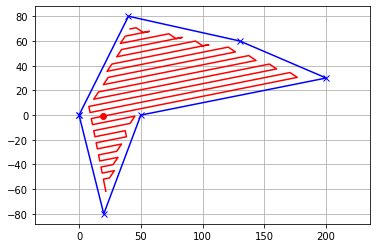

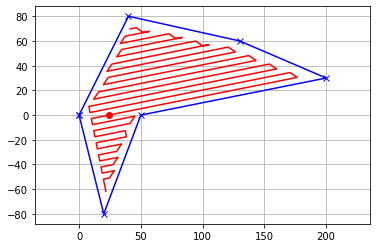

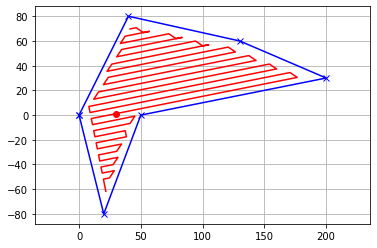

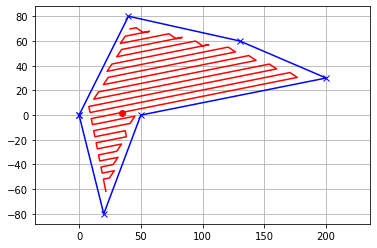

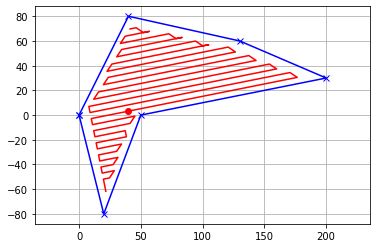

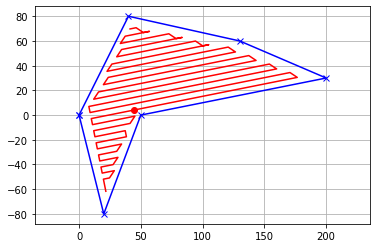

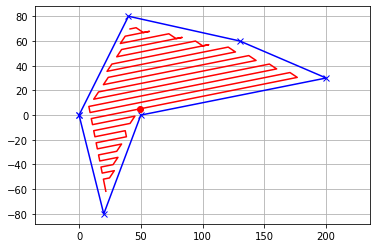

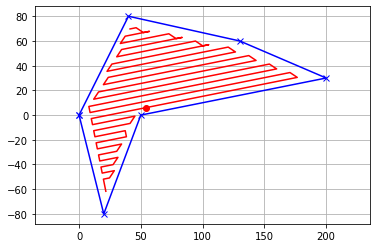

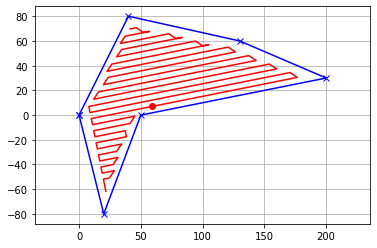

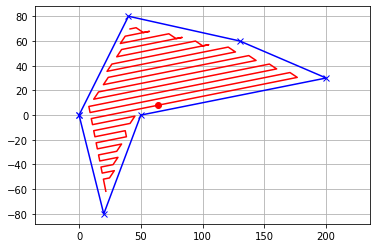

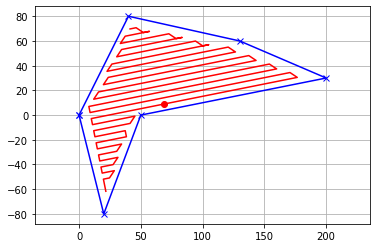

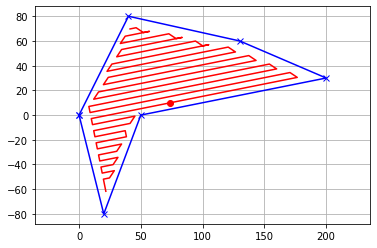

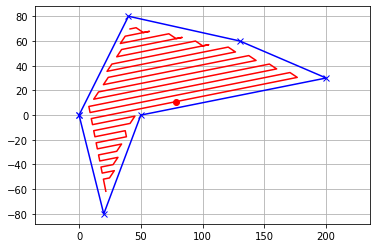

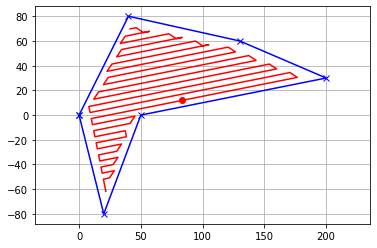

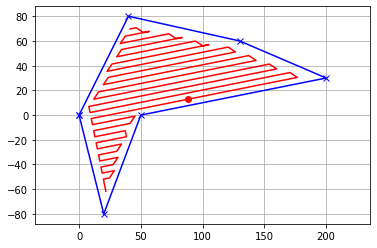

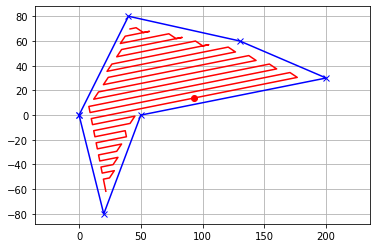

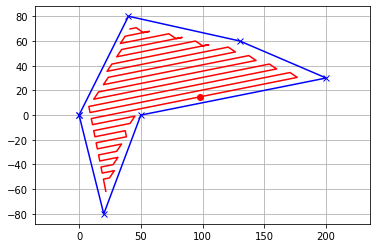

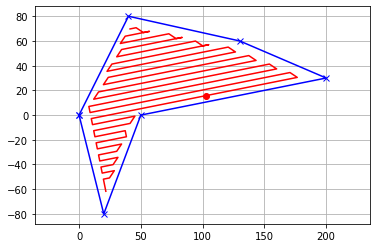

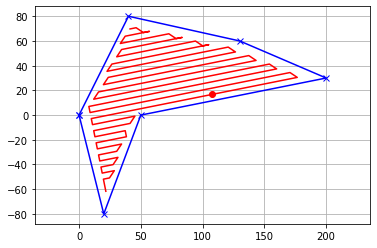

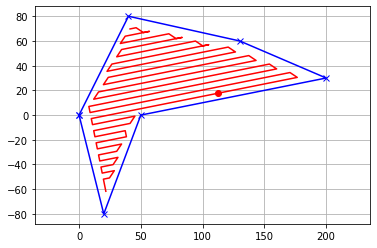

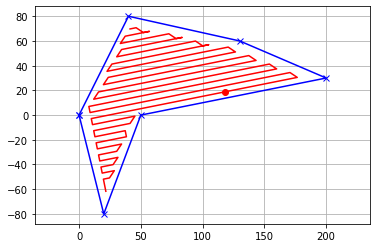

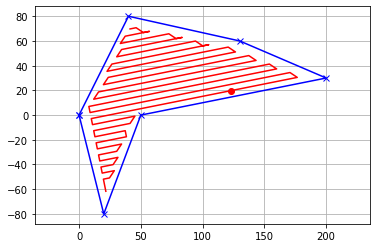

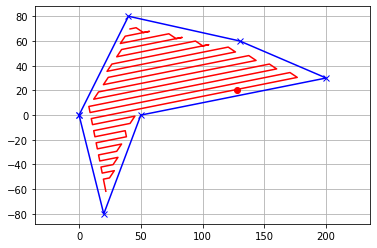

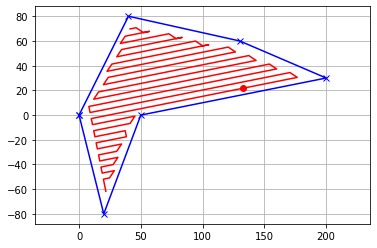

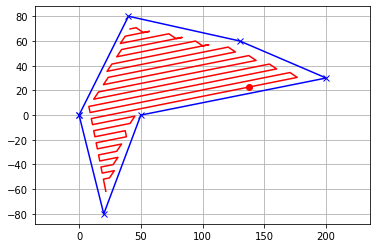

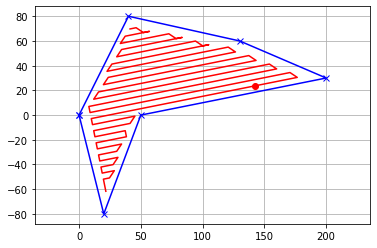

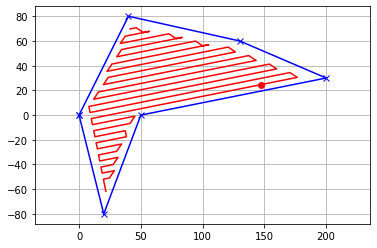

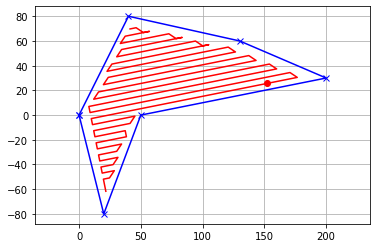

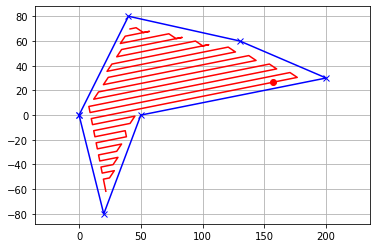

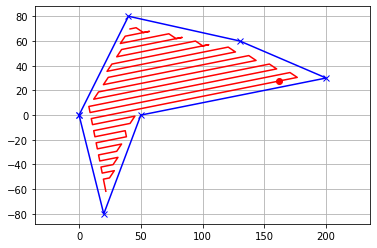

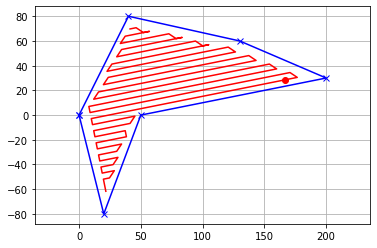

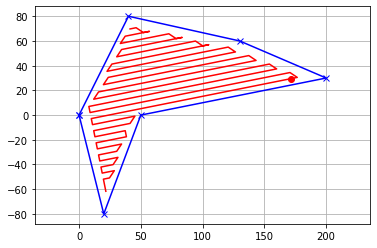

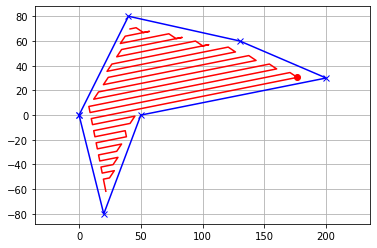

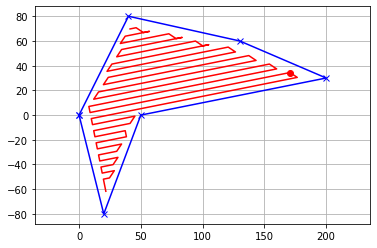

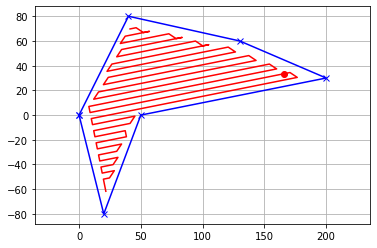

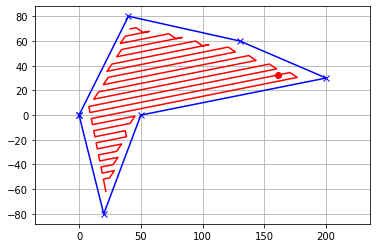

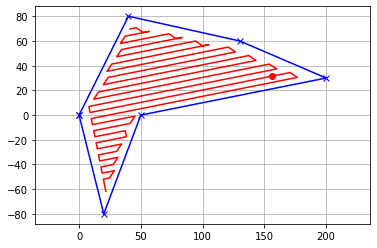

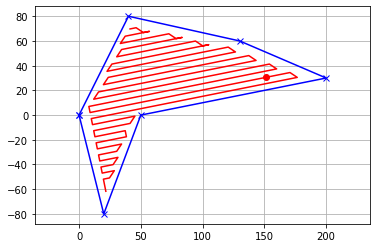

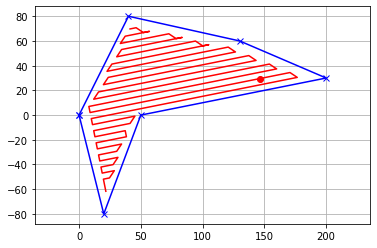

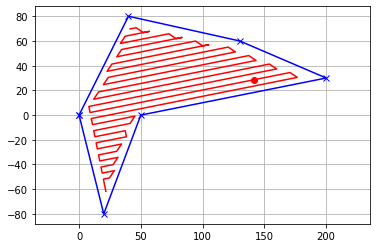

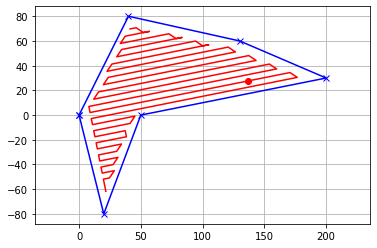

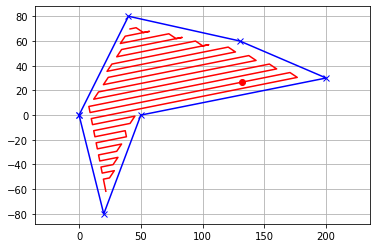

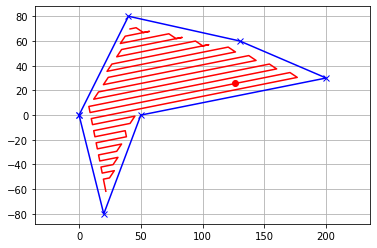

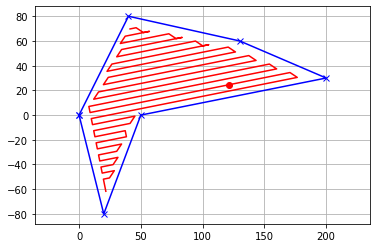

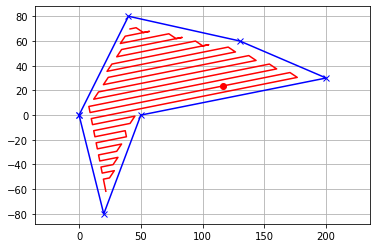

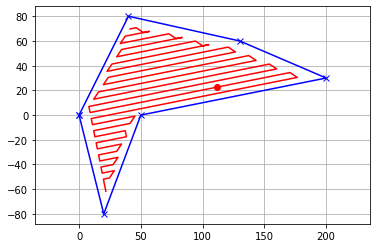

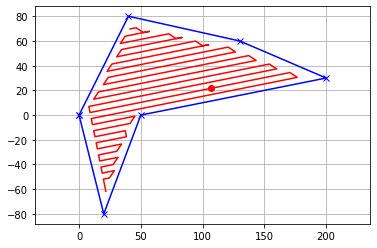

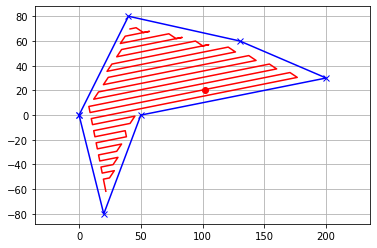

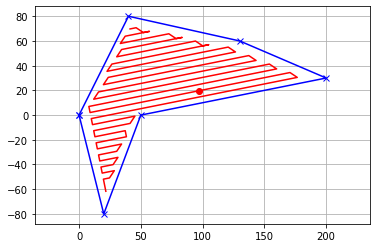

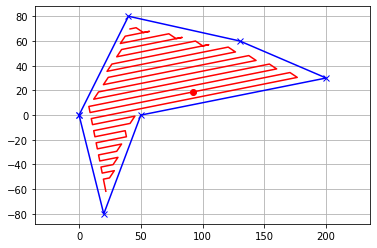

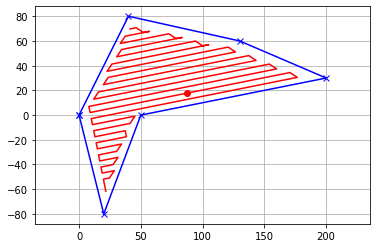

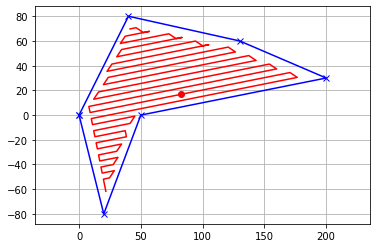

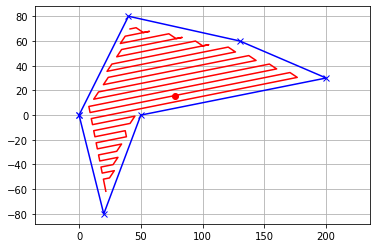

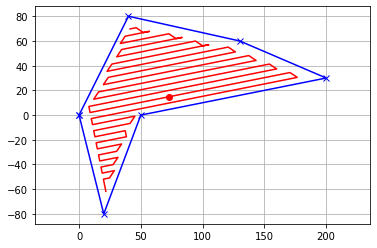

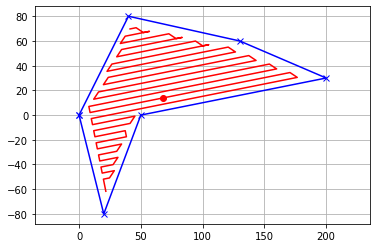

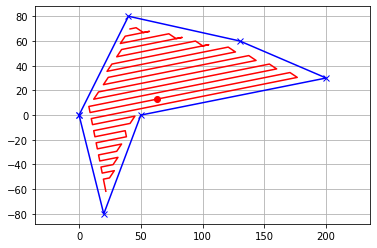

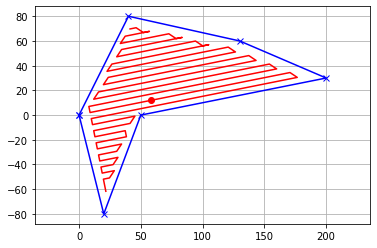

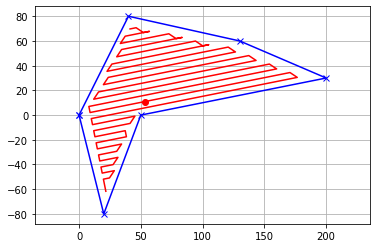

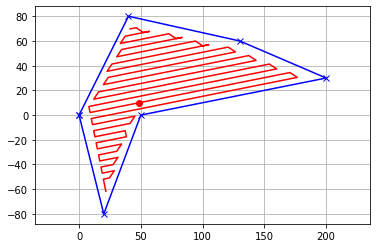

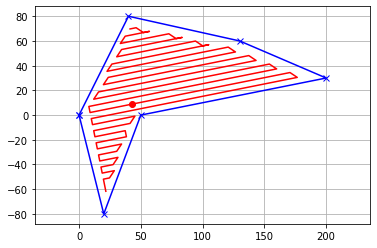

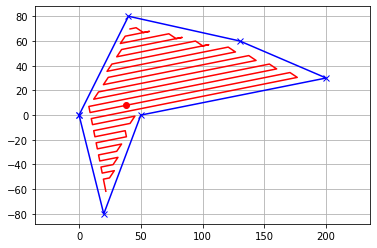

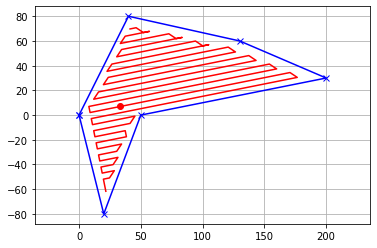

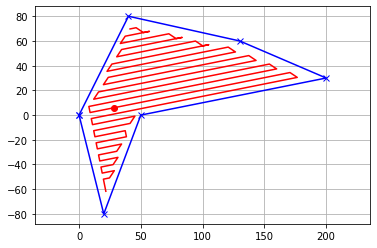

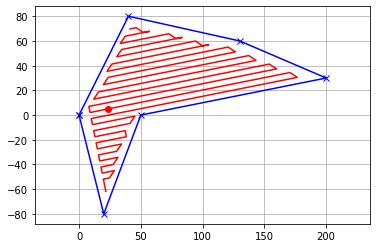

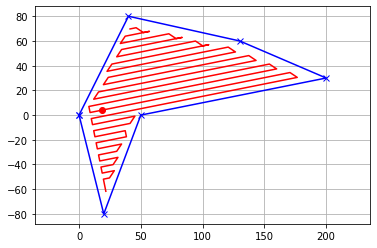

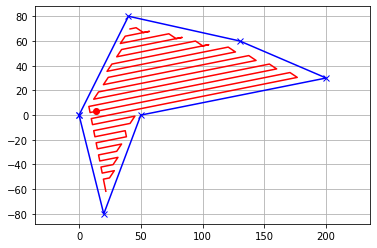

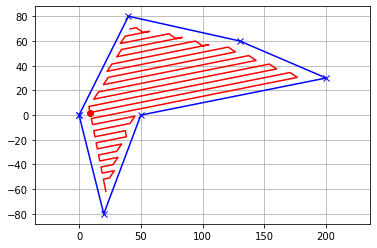

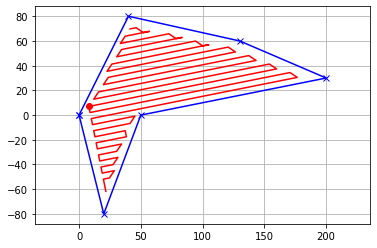

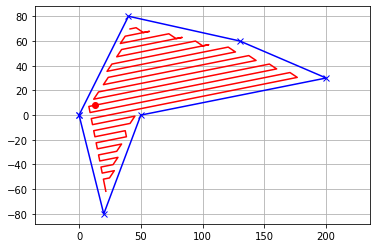

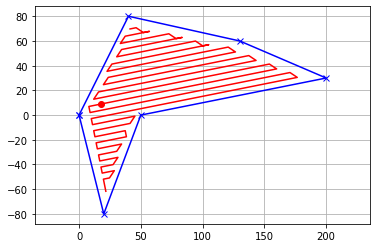

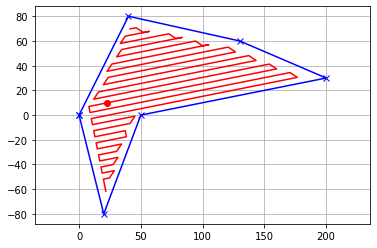

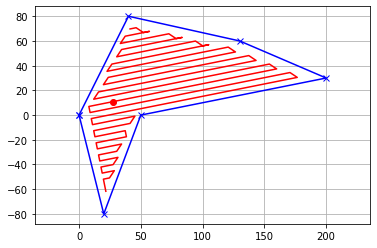

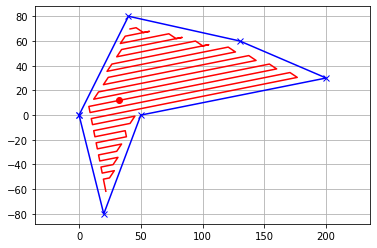

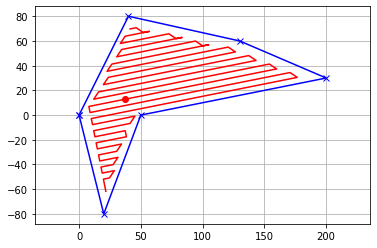

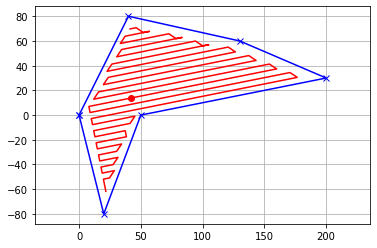

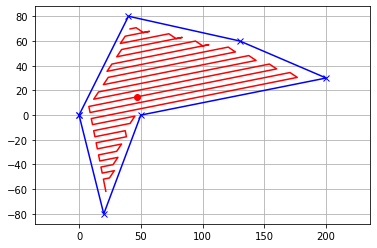

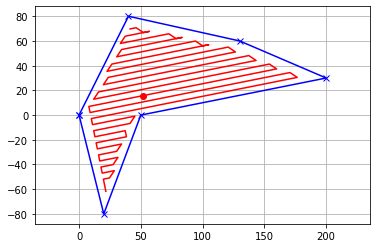

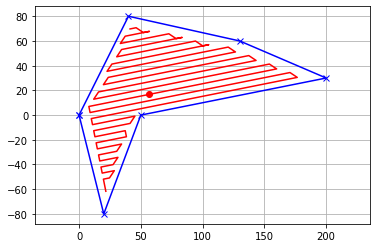

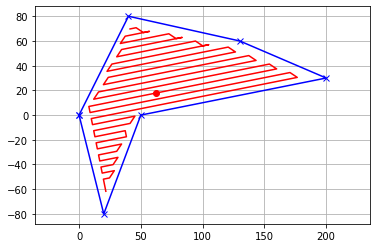

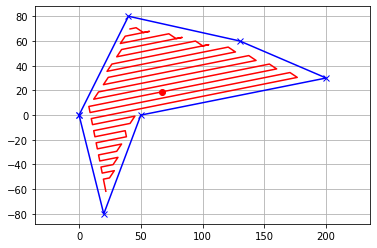

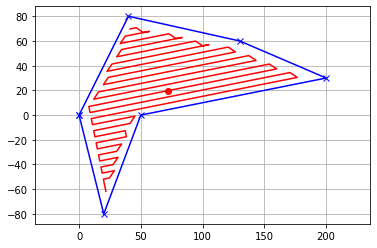

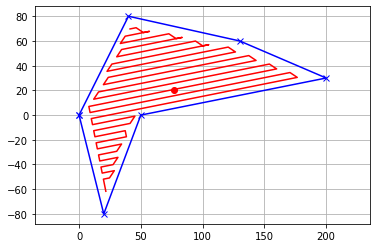

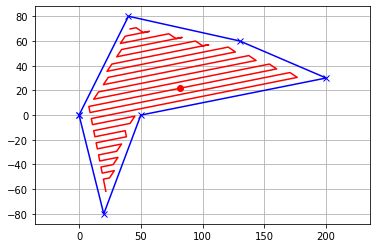

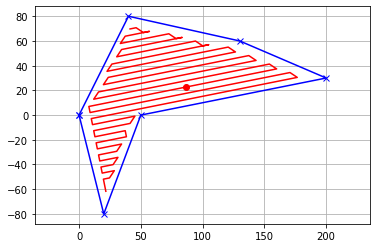

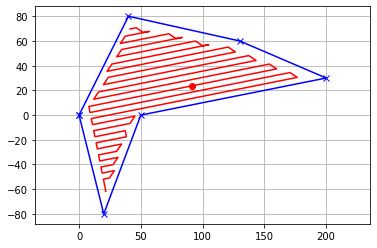

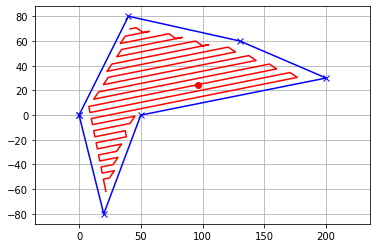

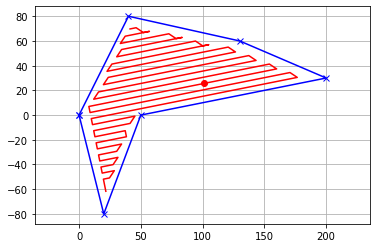

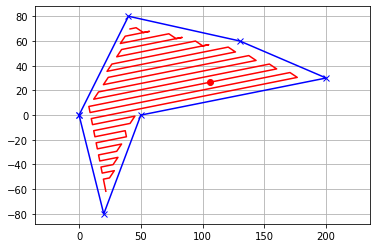

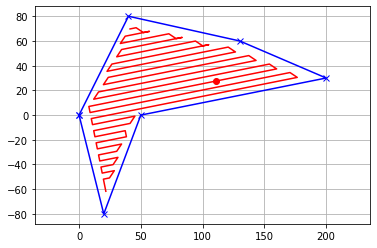

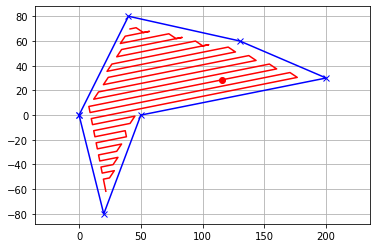

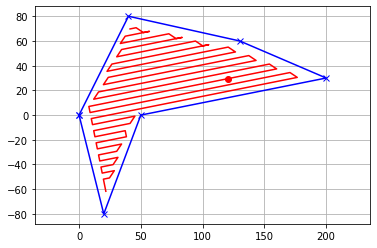

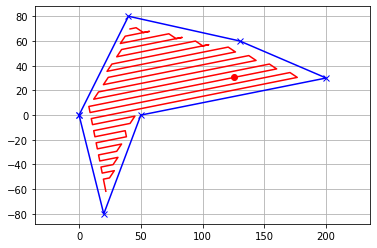

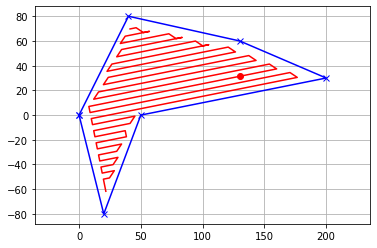

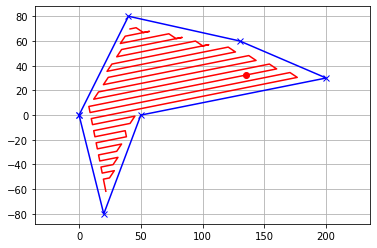

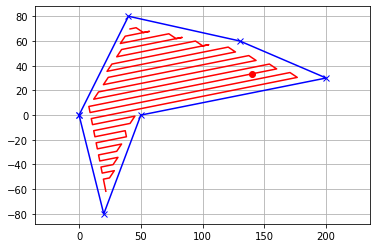

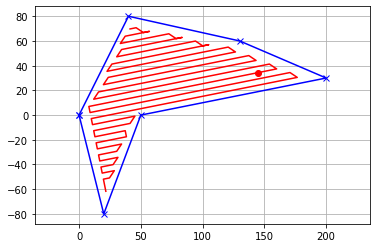

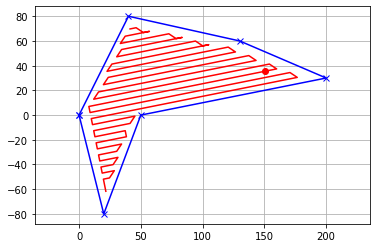

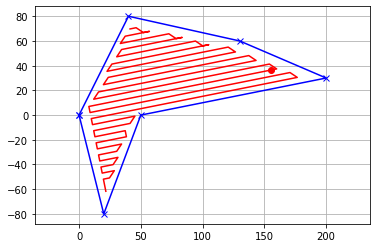

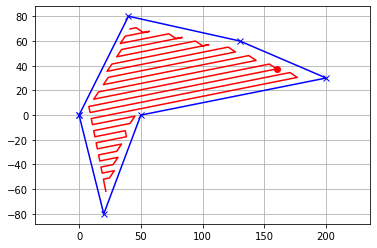

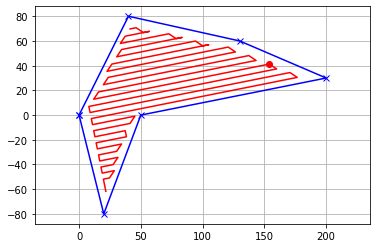

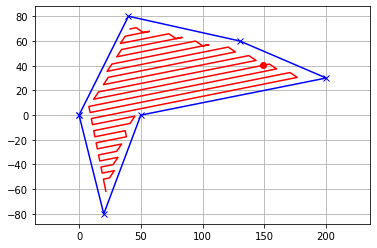

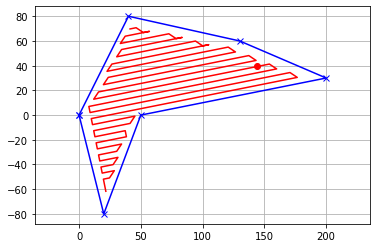

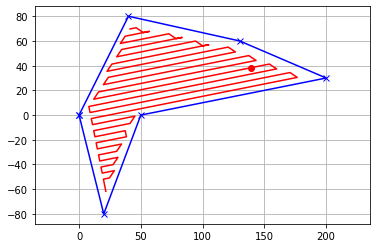

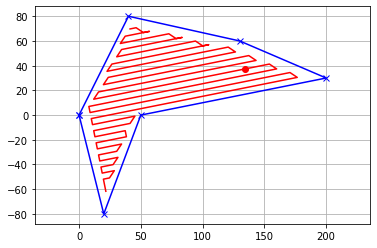

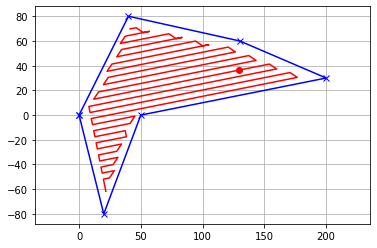

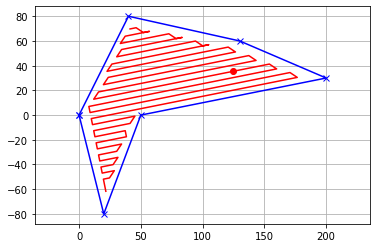

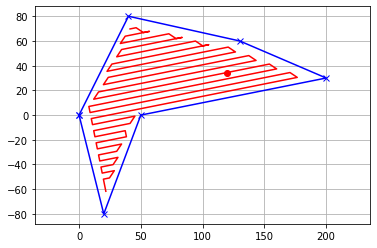

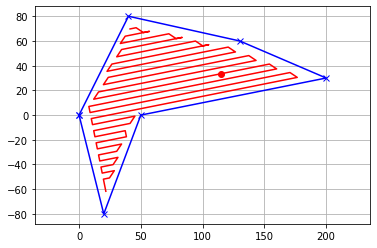

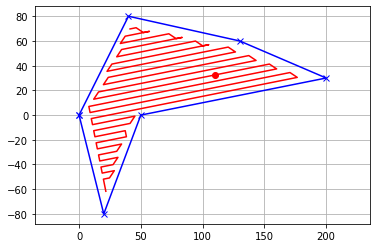

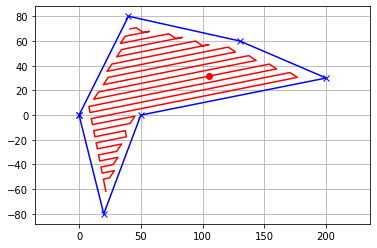

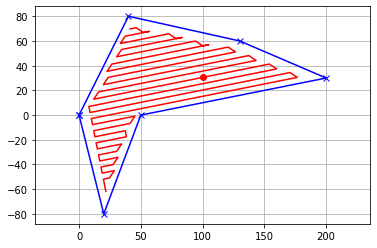

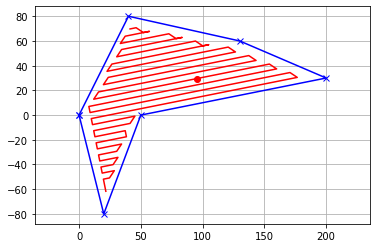

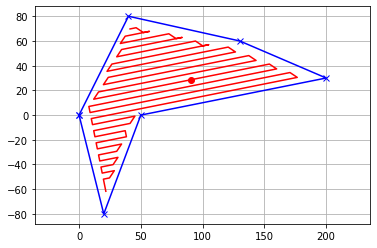

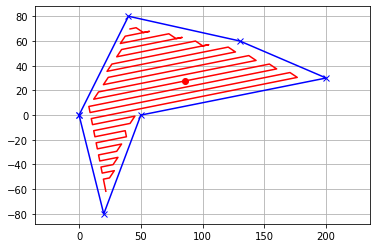

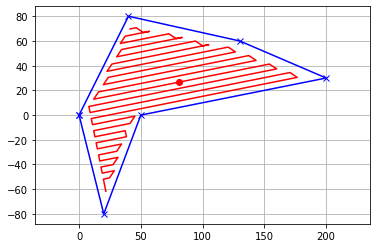

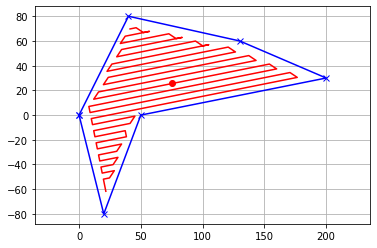

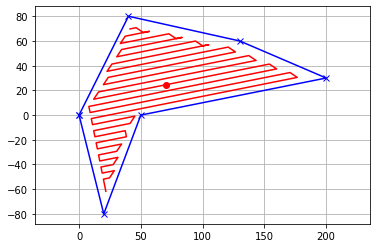

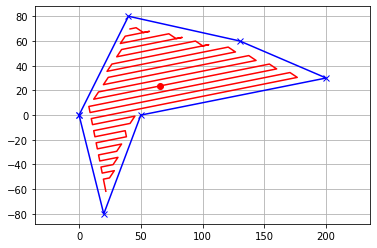

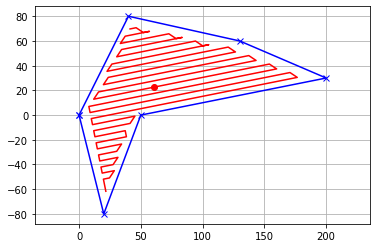

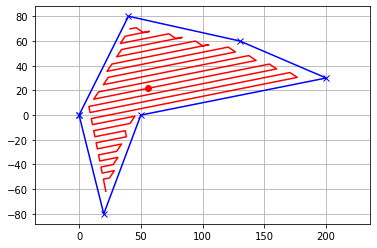

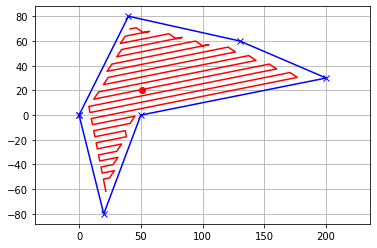

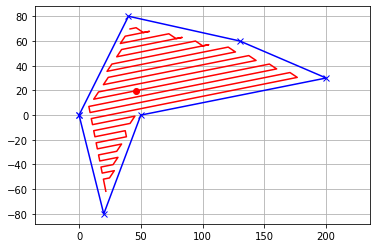

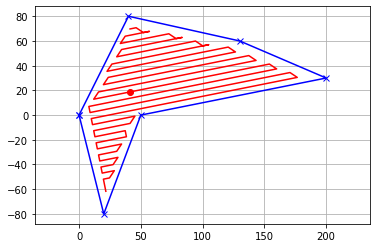

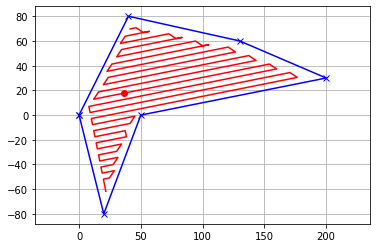

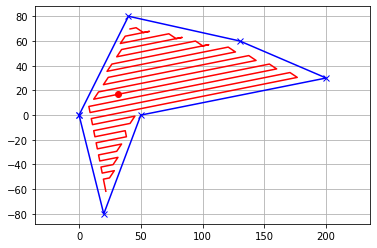

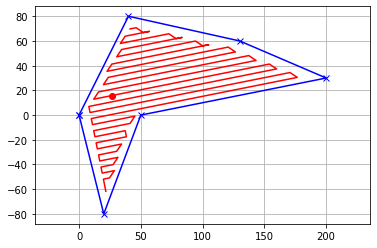

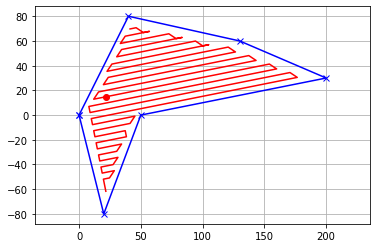

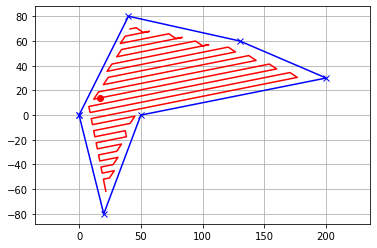

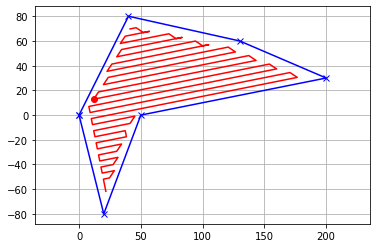

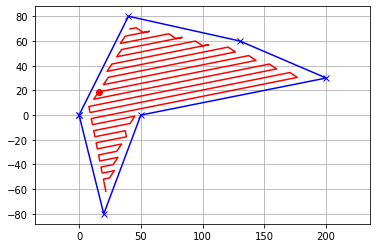

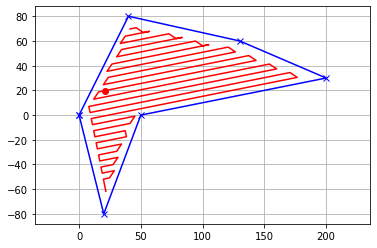

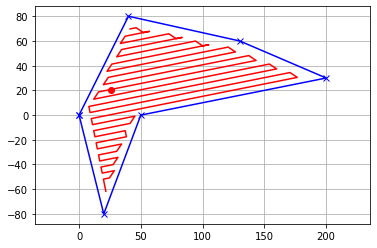

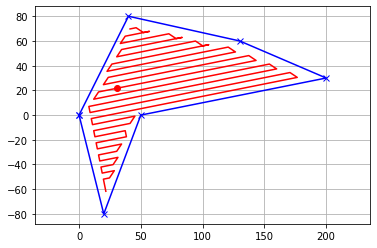

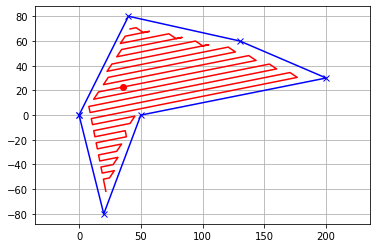

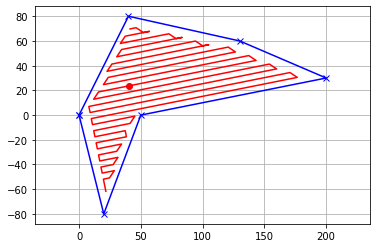

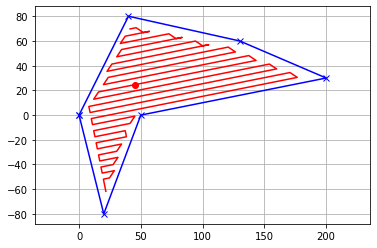

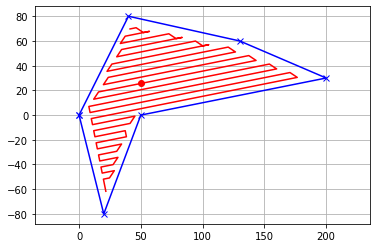

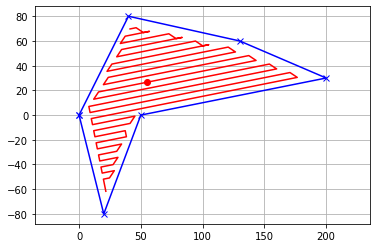

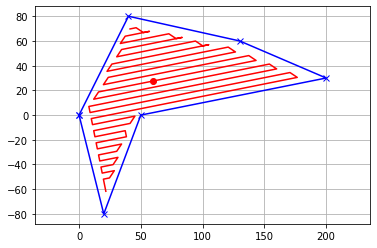

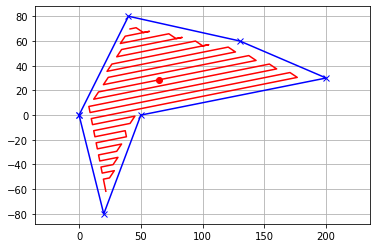

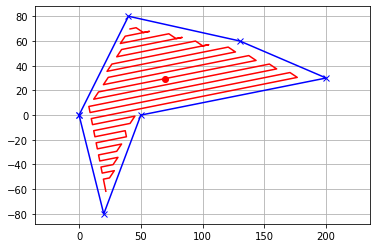

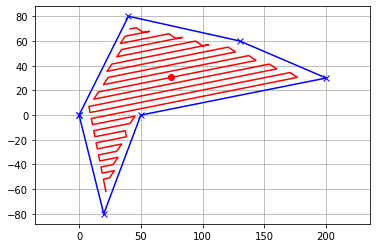

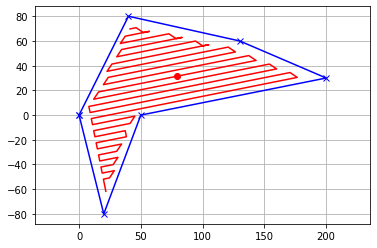

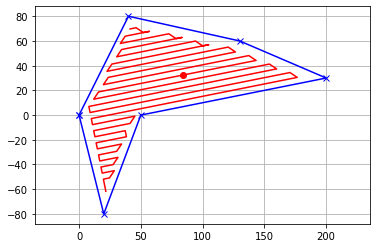

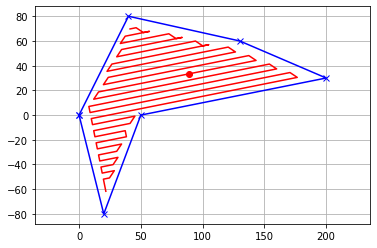

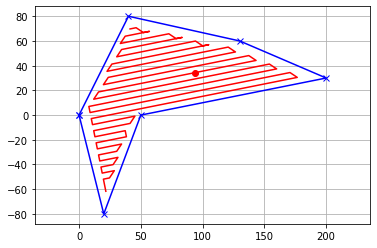

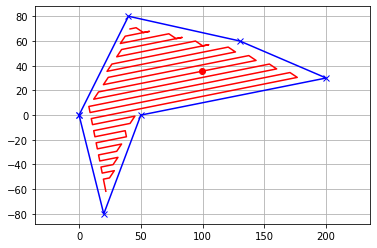

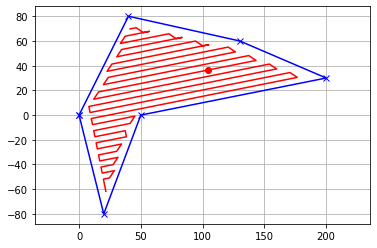

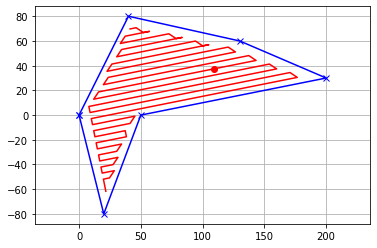

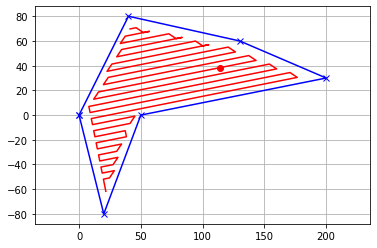

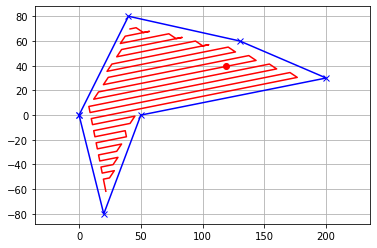

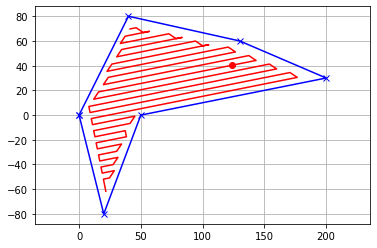

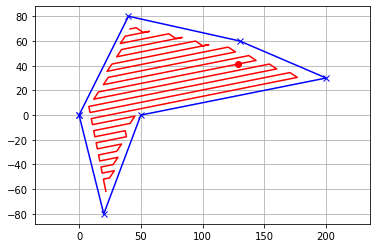

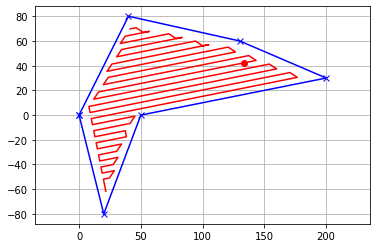

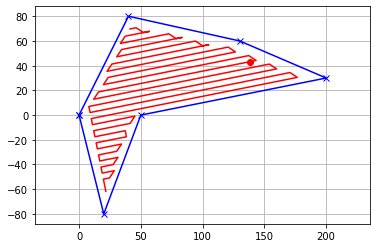

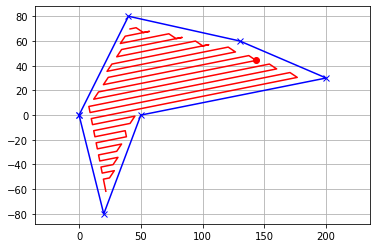

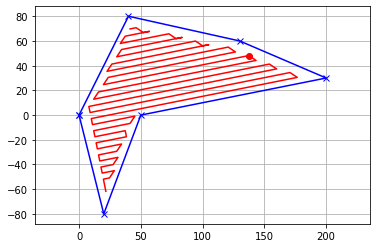

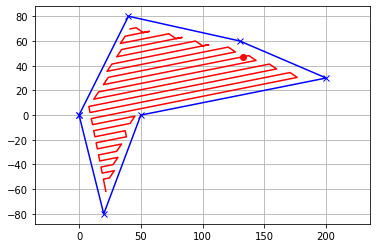

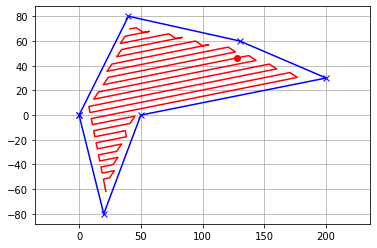

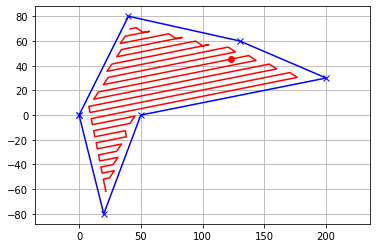

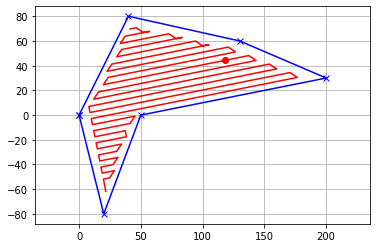

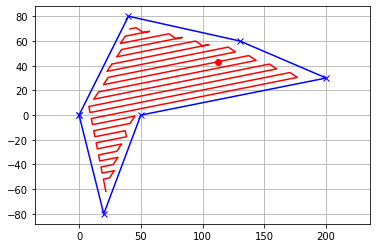

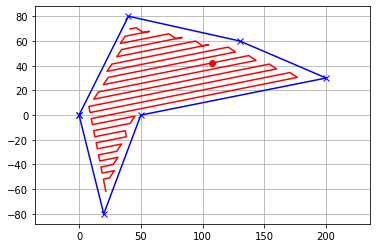

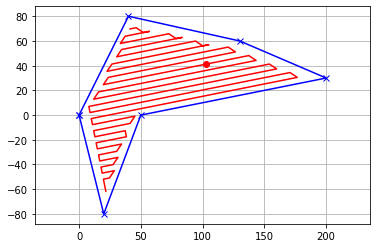

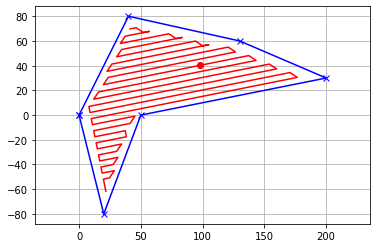

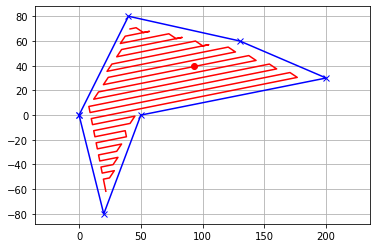

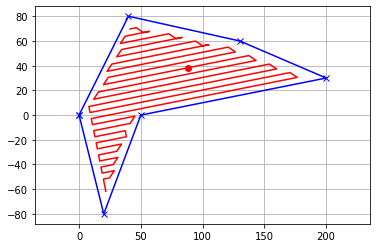

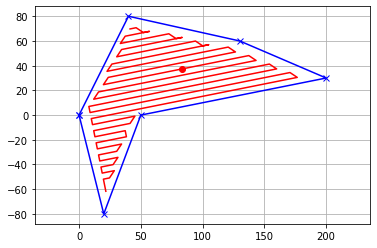

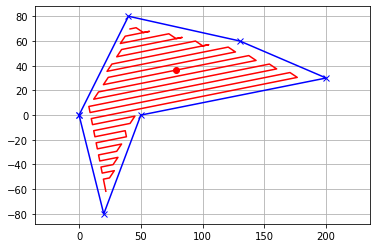

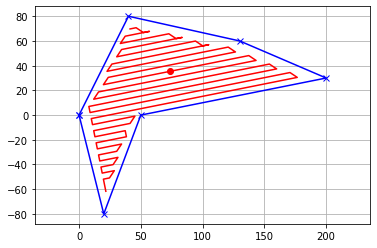

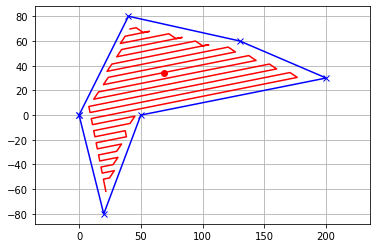

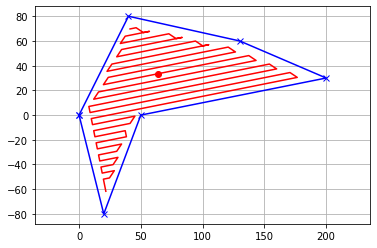

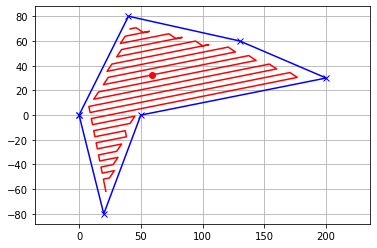

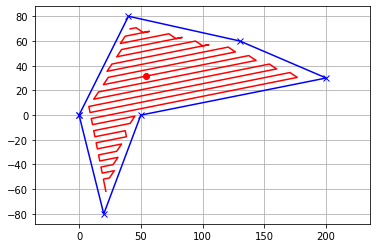

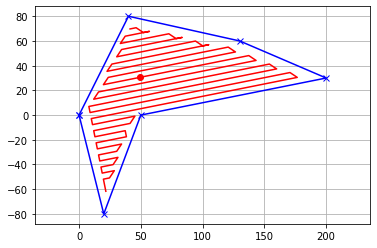

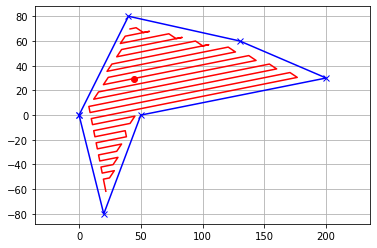

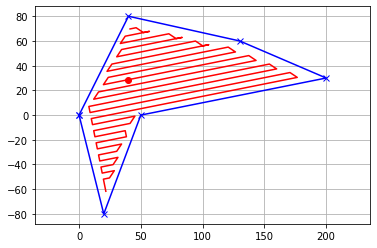

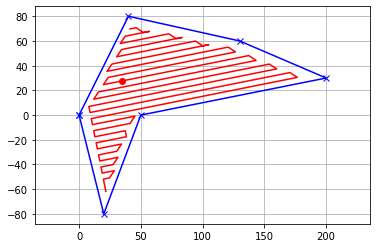

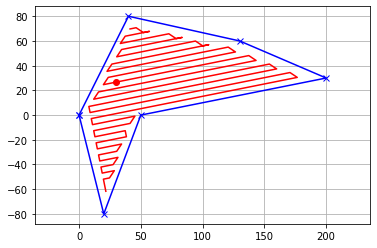

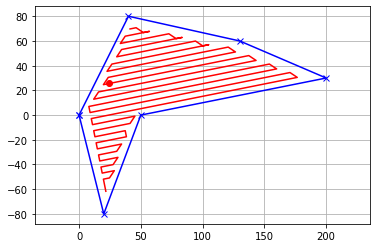

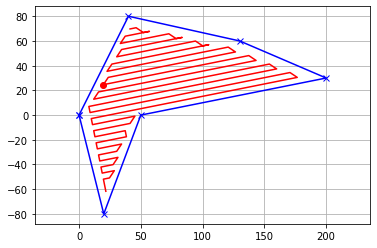

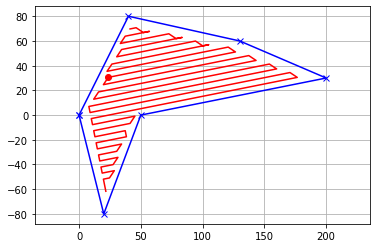

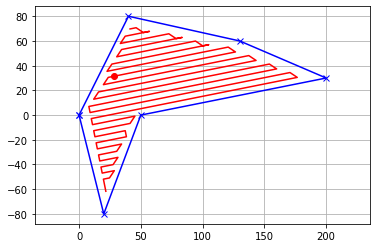

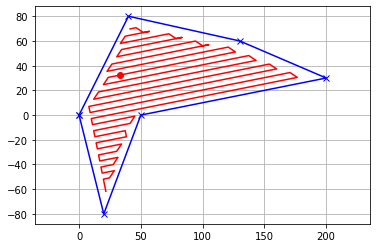

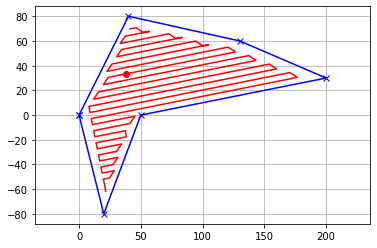

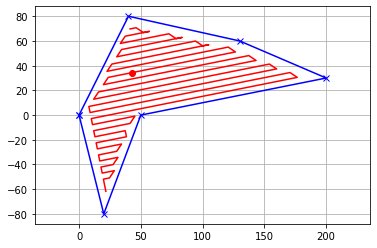

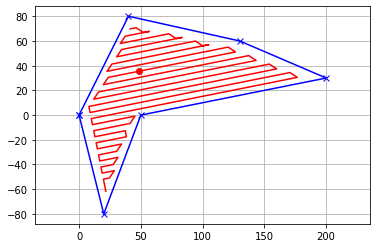

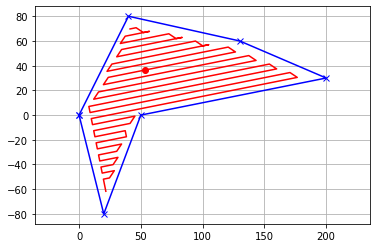

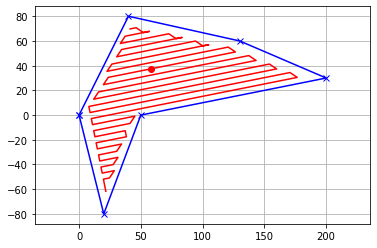

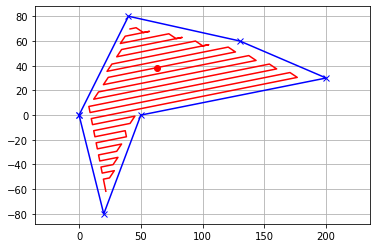

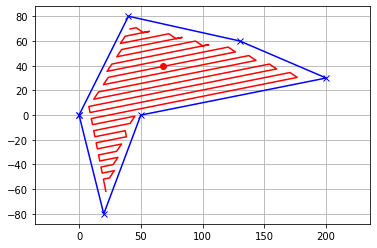

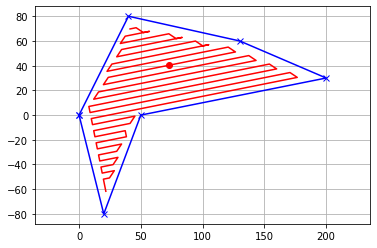

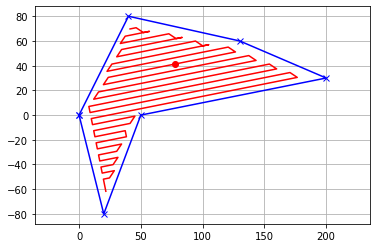

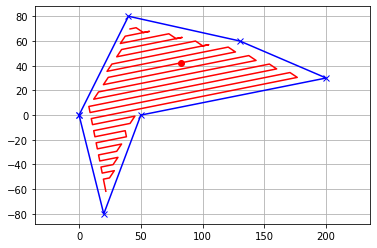

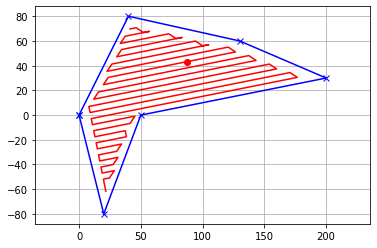

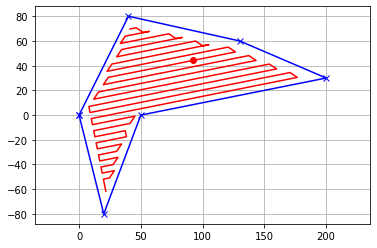

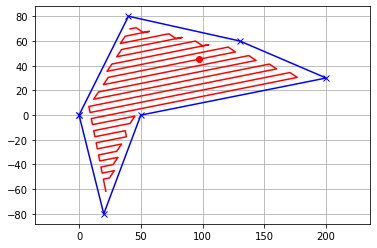

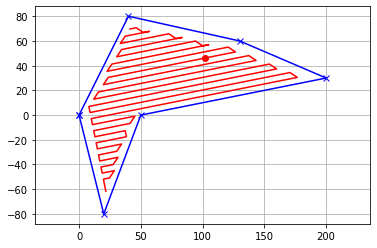

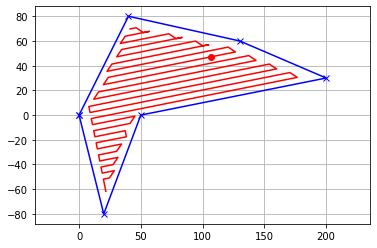

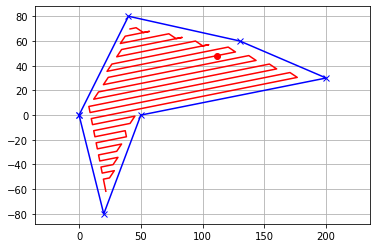

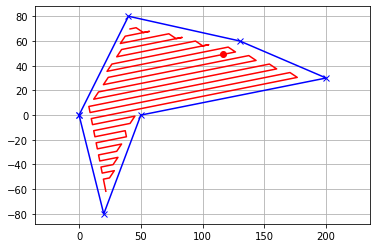

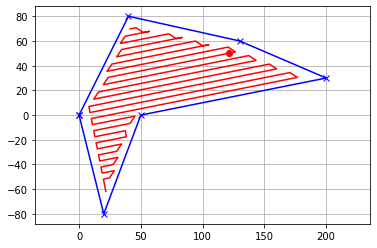

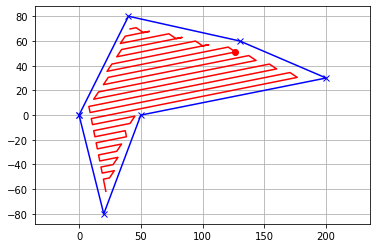

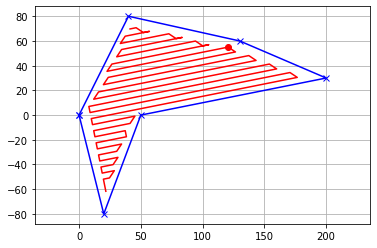

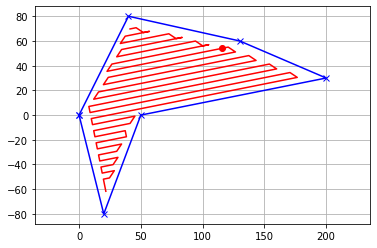

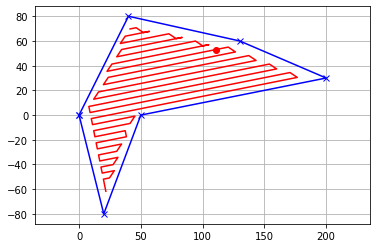

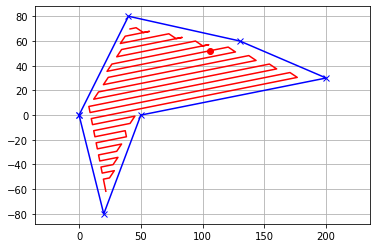

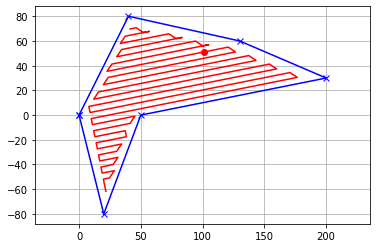

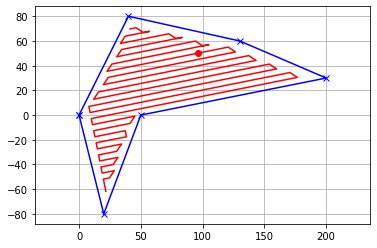

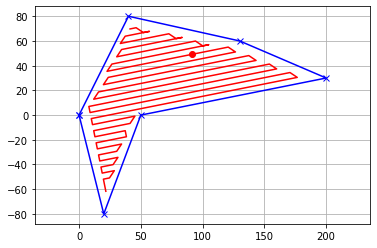

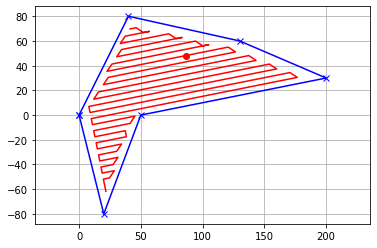

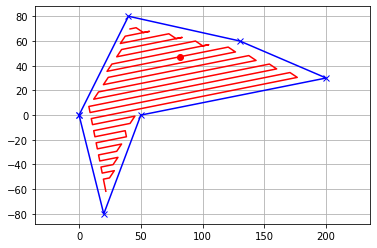

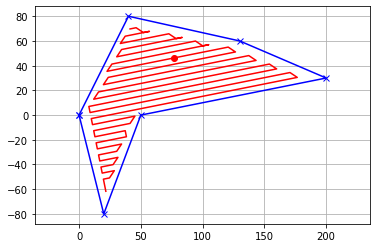

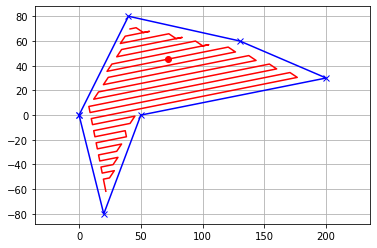

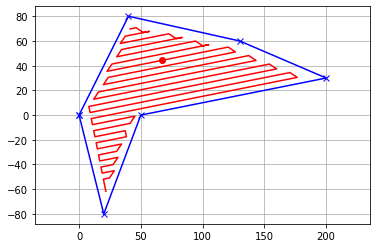

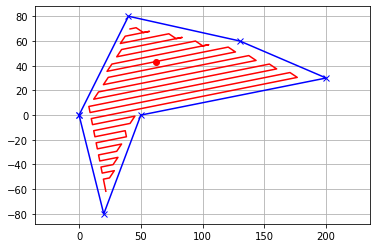

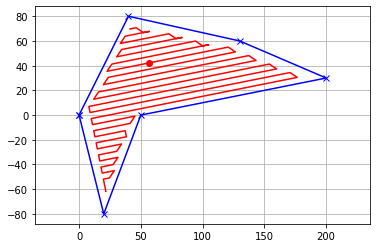

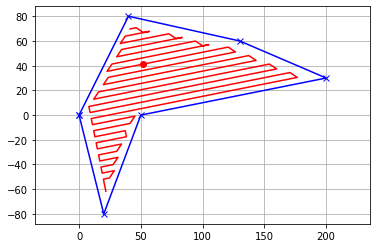

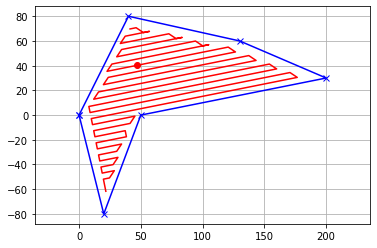

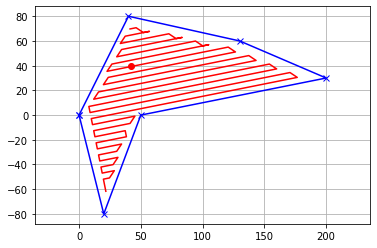

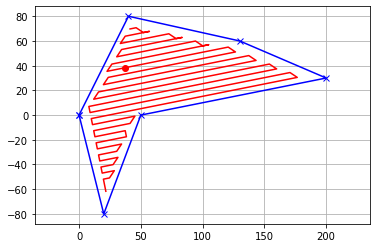

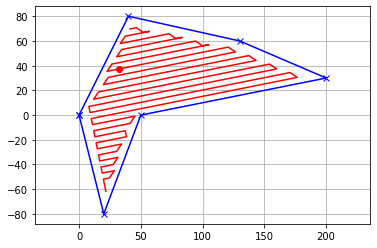

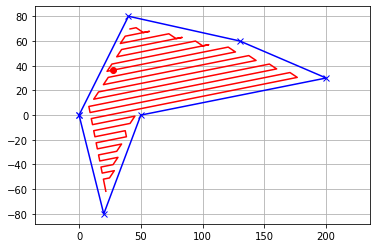

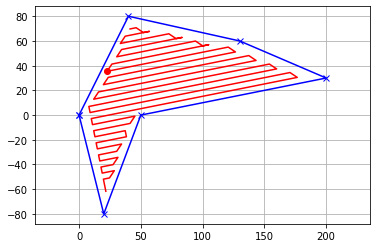

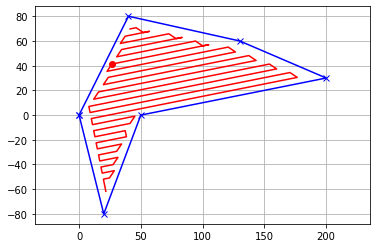

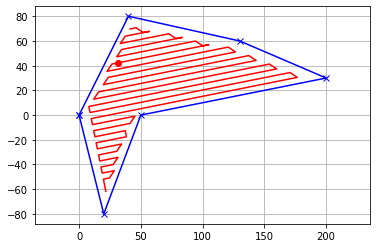

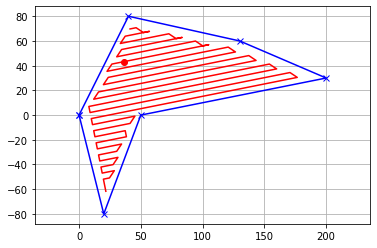

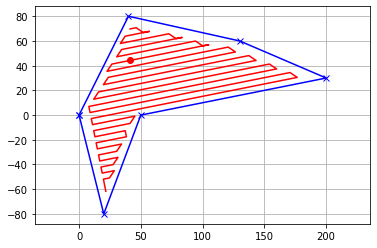

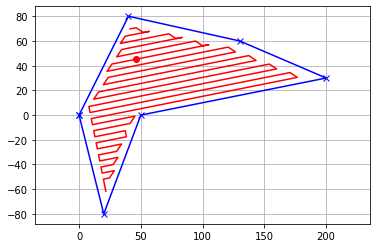

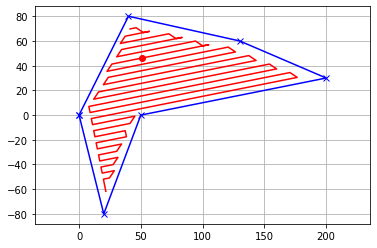

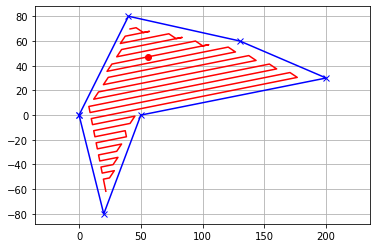

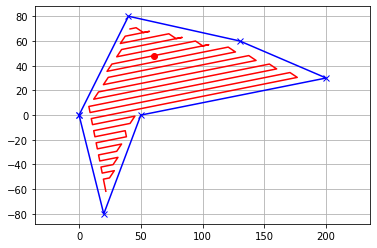

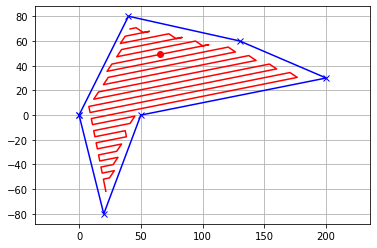

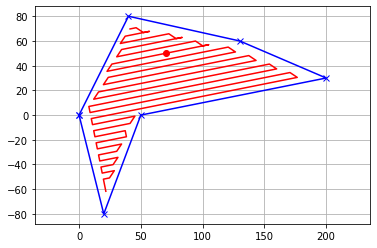

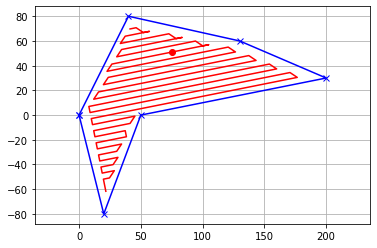

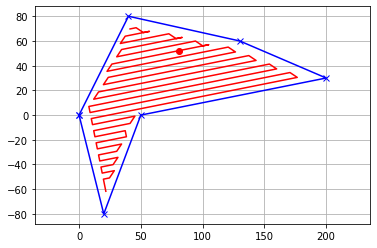

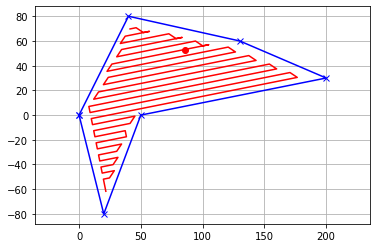

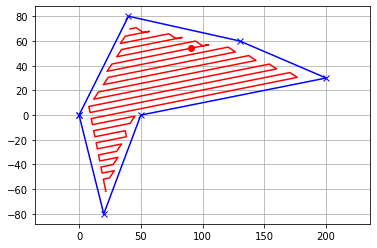

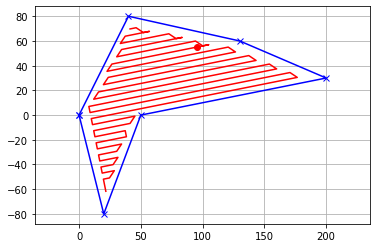

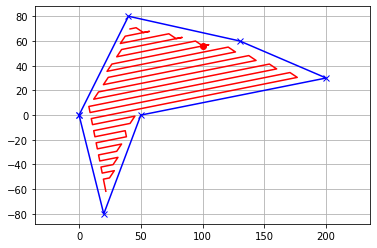

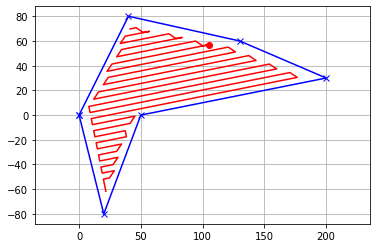

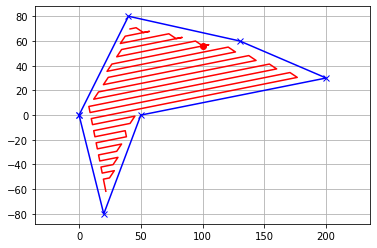

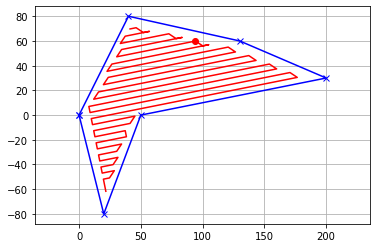

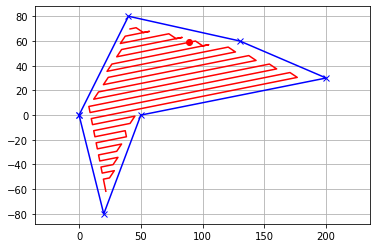

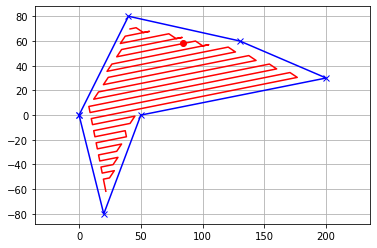

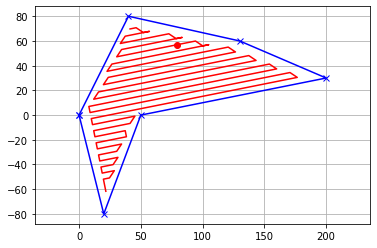

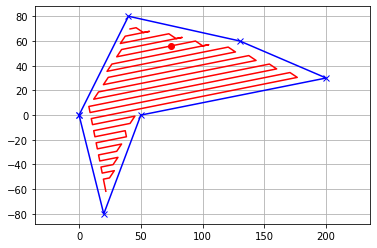

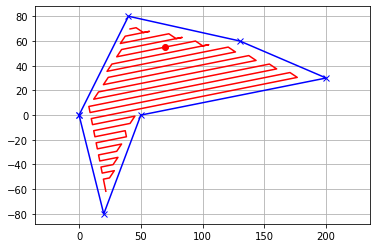

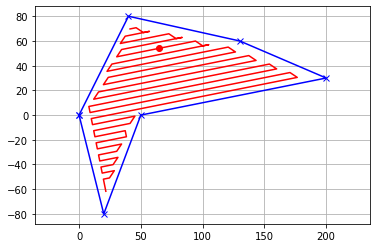

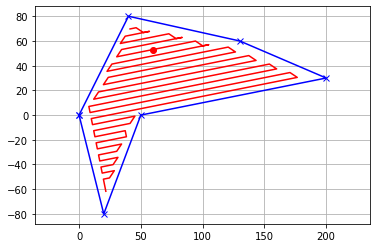

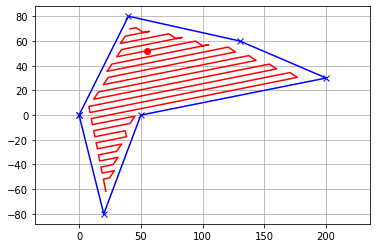

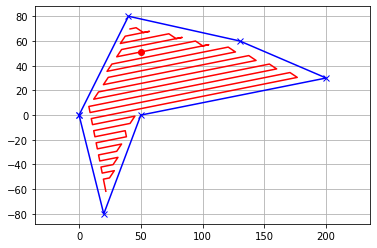

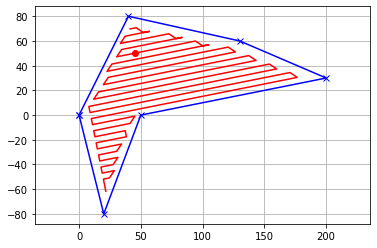

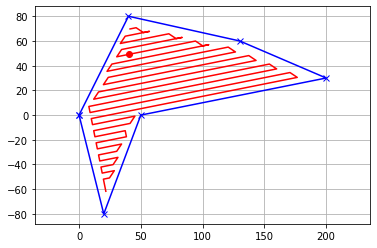

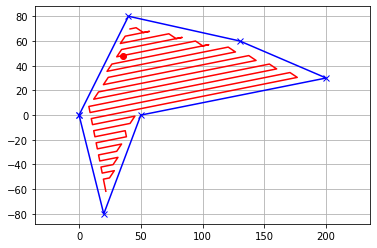

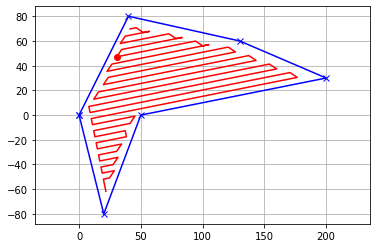

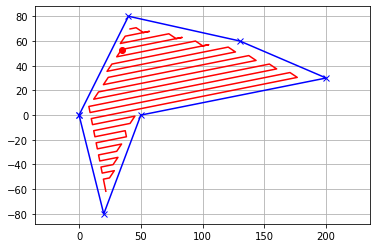

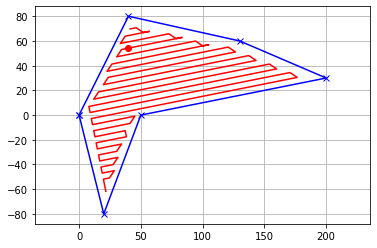

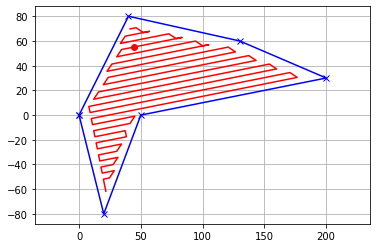

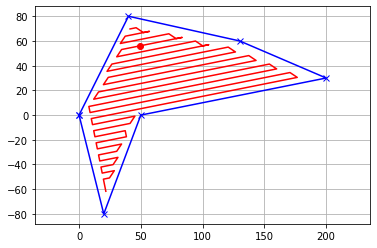

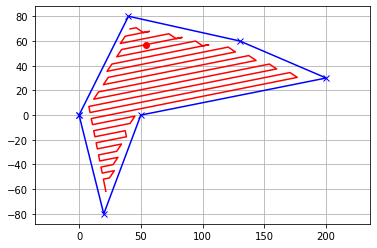

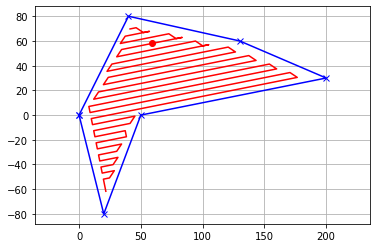

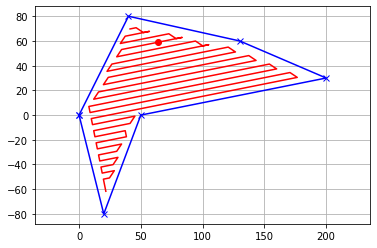

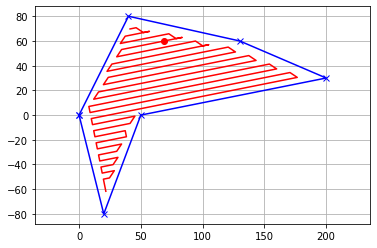

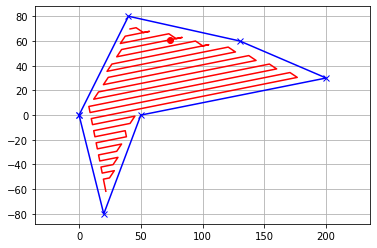

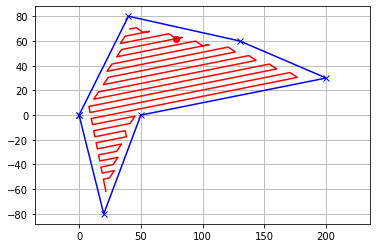

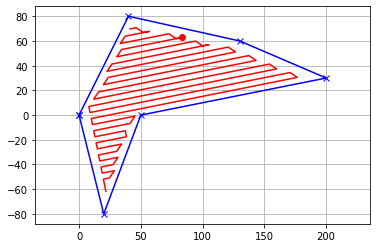

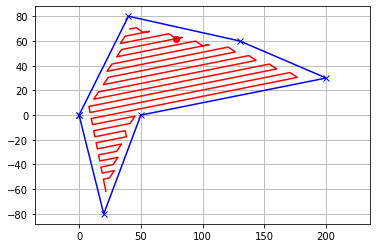

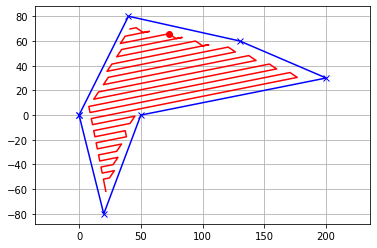

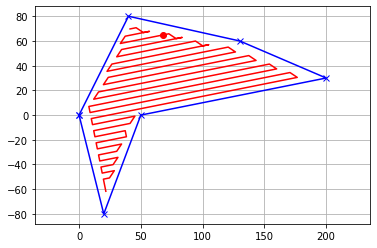

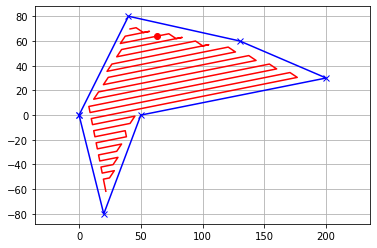

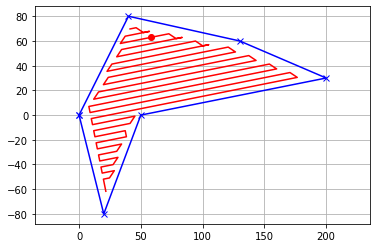

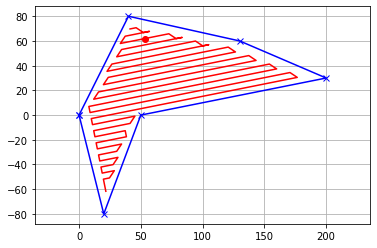

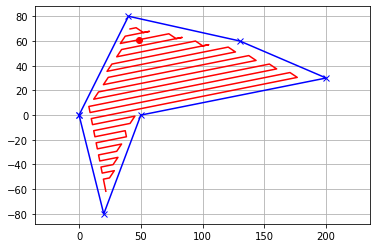

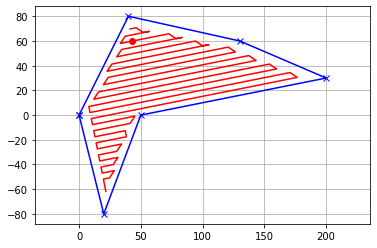

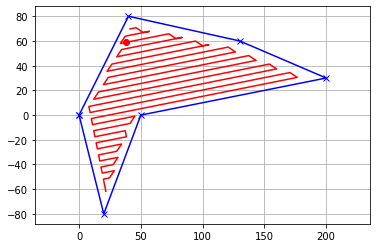

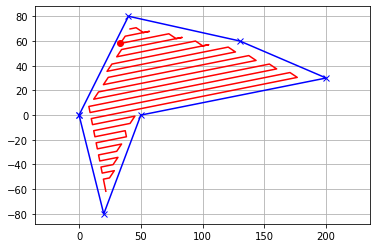

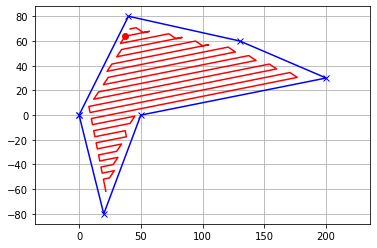

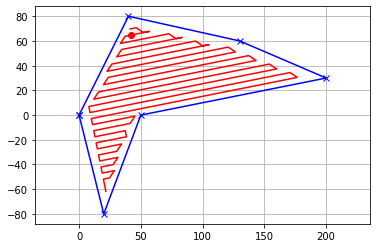

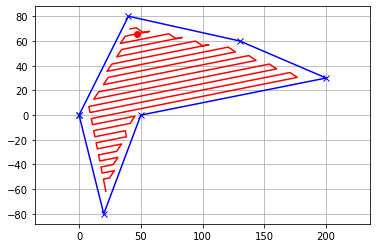

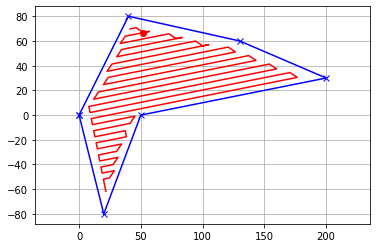

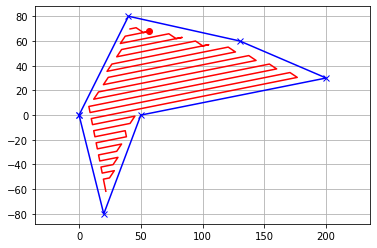

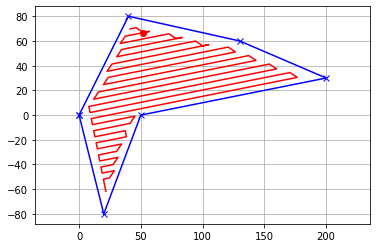

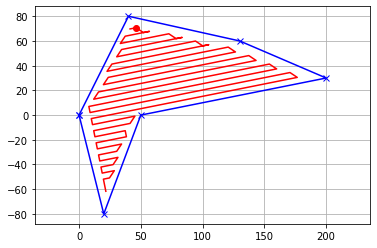

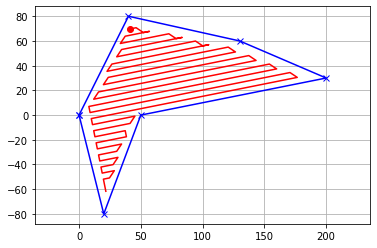

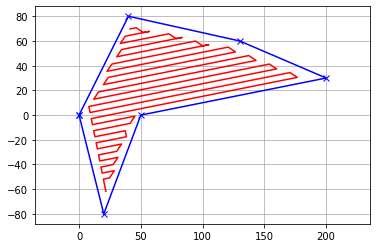

done!!


In [6]:
main()